In [1]:
import matplotlib.pyplot as plt

import datetime

import pandas as pd
from pandas import DataFrame
from pandas import Series

import numpy as np

import seaborn as sns 

import yfinance as yfin

from pypfopt import expected_returns
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import keras as k

from pmdarima.arima import auto_arima

import random

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from scipy.optimize import minimize

from dataclasses import dataclass

### 1. Preparazione dei dati

In [2]:
# gestione dei valori NULL
def handling_null_values(df):
    if df.isnull().sum()['Adj Close'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Adj Close'] = imputer.fit_transform(df['Adj Close'].values.reshape(-1, 1))

    if df.isnull().sum()['Close'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Close'] = imputer.fit_transform(df['Close'].values.reshape(-1, 1))
    
    if df.isnull().sum()['Open'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Open'] = imputer.fit_transform(df['Open'].values.reshape(-1, 1))
    
    if df.isnull().sum()['High'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['High'] = imputer.fit_transform(df['High'].values.reshape(-1, 1))
                                                
    if df.isnull().sum()['Low'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df['Low'] = imputer.fit_transform(df['Low'].values.reshape(-1, 1))

    if df.isnull().sum()['Volume'] != 0:
        imputer = KNNImputer (n_neighbors=2)
        df['Volume'] = imputer.fit_transform(df['Volume'].values.reshape(-1, 1))

    return df

In [3]:
# ticker scelti per il portafoglio
tickers = ['AAPL', 'JNJ', 'CAT', 'DIS', 'HD', 'CVX', 'MSFT', 'V', 'WMT', 'UNH']

# tickers = ['AAPL', 'MSFT', 'CSCO', 'AMZN', 'BRK-A', 'NVDA', 'V', 'JPM', 'UNH', 
           # 'JNJ'] 

start_time = datetime.datetime(2009, 12, 31) # 2009-12-31
end_time = datetime.datetime(2021, 12, 31) # 2021-12-31
time_step = 100
     

# dove si divide dataset di training e validation
all_split = 2517 # inizio 31/12/2009, data di split 02/01/2020, fine 31/12/2021
  

# creo datafrmae scaricando i valori delle 10 azioni per ogni giorno
df = yfin.download(tickers[0], start_time, end_time)
df.index = pd.to_datetime(df.index)

# dataframe contenente Adj Close price (prezzo a fine giornata)
act_adj_close_df = pd.DataFrame(index=df.index, columns=tickers)
for ticker in tickers:
    stock_price_df = yfin.download(ticker, start_time, end_time)
    stock_price_df.index = pd.to_datetime(stock_price_df.index)
    handling_null_values(stock_price_df)
    act_adj_close_df[ticker] = stock_price_df['Adj Close']
     

act_adj_close_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL        JNJ        CAT        DIS         HD        CVX  \
Date                                                                          
2009-12-31  6.362938  42.132004  39.119404  27.999451  20.471846  43.372353   
2010-01-04  6.461976  42.308632  40.190216  27.843180  20.287859  44.538490   
2010-01-05  6.473149  41.818039  40.670719  27.773722  20.436460  44.853973   
2010-01-06  6.370185  42.158161  40.794281  27.626127  20.365700  44.859600   
2010-01-07  6.358408  41.857285  40.959015  27.634808  20.606297  44.690601   

                 MSFT          V        WMT        UNH  
Date                                                    
2009-12-31  23.034222  19.709316  12.961642  24.648186  
2010-01-04  23.389404  19.862555  13.150793  25.497284  
2010-01-05  23.396959  19.634945  13.019843  25.456858  
2010-01-06  23.253370  19.371292  12.990745  25.707535  
2010-01-07  23.011545  19.551573  12.998020  26.694107

In [4]:
print(len(act_adj_close_df))

3021


In [5]:
stock_price_df.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2009-12-31  30.950001  31.150000  30.450001  30.480000  24.648186   5354200
2010-01-04  31.379999  31.600000  30.969999  31.530001  25.497284  12199500
2010-01-05  31.730000  31.969999  31.280001  31.480000  25.456858  11180700
2010-01-06  31.600000  32.060001  31.410000  31.790001  25.707535   9761100
2010-01-07  31.590000  33.049999  31.590000  33.009998  26.694107  11789800

In [123]:
# funzioni usate per fare valutazione dei modelli
def MAE(y_true, y_pred):                                                                        # calcola quanto sono lontane 
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true)), axis=0)                         # le previsioni rispetto all’output originale
 
def MSE(y_true, y_pred):                                                                        # calcola la differenza tra il valore reale
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true))**2, axis=0)                      # e quello previsto elevandola al quadrato, in questo modo gli errori grandi sono più evidenti

def RMSE(y_true, y_pred):                                                                       # radice quadrata della differenza elevata al quadrato
    return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto

def MAPE(y_true, y_pred):                                                                       # misura dell’accuratezza della previsione di un modello
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true)) / np.array(y_true), axis=0)

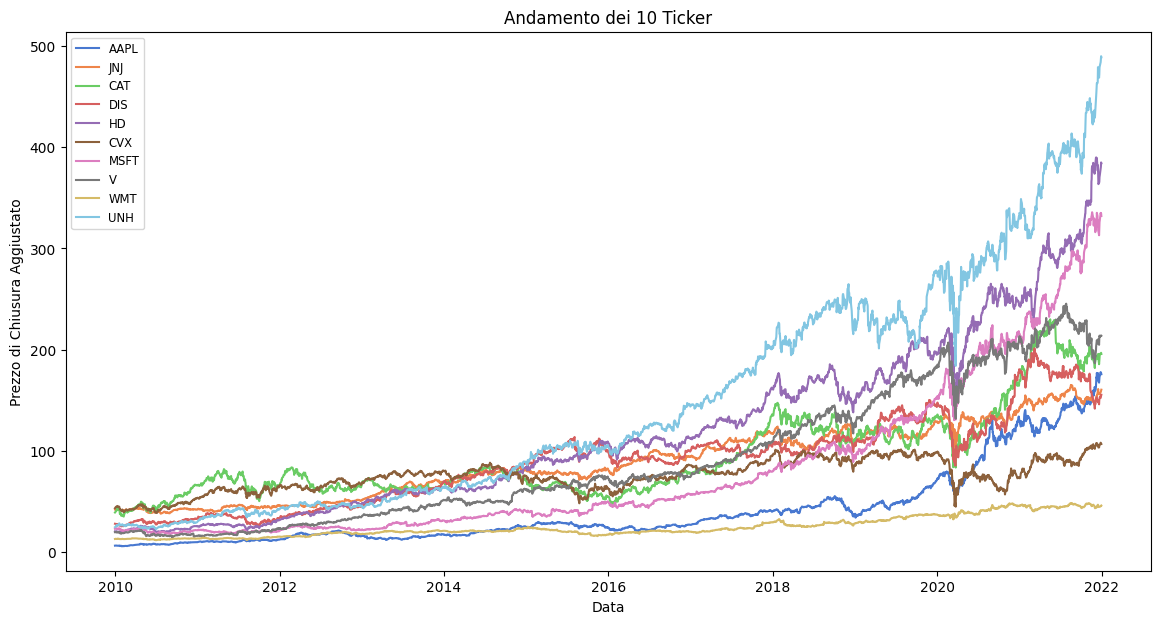

In [7]:
# Definisci la palette di colori
palette = sns.color_palette("muted", len(tickers))  # "husl" è il nome di una delle palette disponibili in seaborn

# Crea il grafico
plt.figure(figsize=(14, 7))

# Aggiungi ciascun ticker al grafico
for i, ticker in enumerate(tickers):
    plt.plot(act_adj_close_df.index, act_adj_close_df[ticker], label=ticker, color=palette[i])

# Aggiungi titoli e legende
plt.title('Andamento dei 10 Ticker')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura Aggiustato')
plt.legend(loc='upper left', fontsize='small')

# Salva l'immagine come file PNG
plt.savefig('andamento_ticker.png')

# Mostra il grafico
plt.show()

### 2. Modello ARIMA

In [176]:
# parte di fondamentale importanza per il modello ARIMA in quanto ha bisogno di una serie stazionaria per funzionare correttamente
# viene applicato il logaritmo sull'intera serie per garantire la stazionarità
act_adj_close_sq_df = np.log(act_adj_close_df)

In [177]:
# crazione del modello auto ARIMA, sceglierà in automatico i valori di p e q migliori in un range da 0 a 5
def create_model_auto_arima(train_set):
    return auto_arima(train_set,
                      start_p=0,
                      start_q=0,
                      test='adf',
                      max_p=5,
                      max_q=5,
                      m=1,
                      d=None,
                      seasonal=False,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

In [178]:
max_train = 2508
time_steps = 19

In [179]:
# creazione dei dataframe dei risultati
ARIMA_prediction_df = pd.DataFrame(index=df.index[max_train:], columns=tickers)
ARIMA_model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE'], columns=tickers)
ARIMA_model_loss_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE'], columns=tickers)
ARIMA_upper = pd.DataFrame(index=df.index[max_train :], columns=tickers)
ARIMA_lower = pd.DataFrame(index=df.index[max_train :], columns=tickers)

In [180]:
# previsione a lungo termine su ogni ticker
for ticker in tickers:
    train_data, test_data = act_adj_close_sq_df[ticker][:max_train], act_adj_close_sq_df[ticker][max_train:]

     # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')


    model = create_model_auto_arima(train_set=train_data)

    history = [x for x in train_data.values]

    prediction = []
    lower_bound = []
    upper_bound = []

    for i in range(time_steps, len(test_data) + time_steps, time_steps):
        model.fit(history)
        yhat, confint = model.predict(time_steps, return_conf_int=True)
        prediction = np.concatenate([prediction, yhat])
        lower_bound = np.concatenate([lower_bound, confint[:, 0]])
        upper_bound = np.concatenate([upper_bound, confint[:, 1]])  
        history = np.concatenate([history, test_data[i - time_steps : i]])  
    
    ARIMA_prediction_df[ticker] = prediction
    ARIMA_lower[ticker] = lower_bound
    ARIMA_upper[ticker] = upper_bound
    ARIMA_model_loss_df[ticker] = [MAE(test_data, ARIMA_prediction_df[ticker]), MSE(test_data, ARIMA_prediction_df[ticker]), RMSE(test_data, ARIMA_prediction_df[ticker]), 
                                  MAPE(test_data, ARIMA_prediction_df[ticker])]

----------
AAPL fitting...
9 left
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13535.125, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13533.838, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13533.858, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13528.657, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13531.520, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.826 seconds
----------
JNJ fitting...
8 left
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16229.136, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16229.369, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16229.500, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16225.766, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16227.768, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16229.854, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0

In [181]:
# riporto i dati nella loro forma originale
ARIMA_prediction_df = np.exp(ARIMA_prediction_df)
ARIMA_lower = np.exp(ARIMA_lower)
ARIMA_upper = np.exp(ARIMA_upper)

In [182]:
# stampo gli ultimi valori predetti
ARIMA_prediction_df.tail()

AAPL         JNJ         CAT         DIS          HD  \
Date                                                                     
2021-12-23  164.116148  147.250295  188.329484  147.530992  387.206310   
2021-12-27  164.293097  147.310637  188.427644  147.611375  387.581429   
2021-12-28  164.470237  147.371004  188.525855  147.691802  387.956910   
2021-12-29  164.647568  147.431396  188.624118  147.772272  388.332756   
2021-12-30  164.825090  147.491812  188.722431  147.852787  388.708966   

                   CVX        MSFT           V        WMT         UNH  
Date                                                                   
2021-12-23  104.723343  326.747118  195.971826  43.630685  436.943520  
2021-12-27  104.723343  327.034015  196.120966  43.647965  437.360250  
2021-12-28  104.723343  327.321164  196.270220  43.665253  437.777376  
2021-12-29  104.723343  327.608565  196.419588  43.682547  438.194901  
2021-12-30  104.723343  327.896218  196.569069  43.699848  438.612823

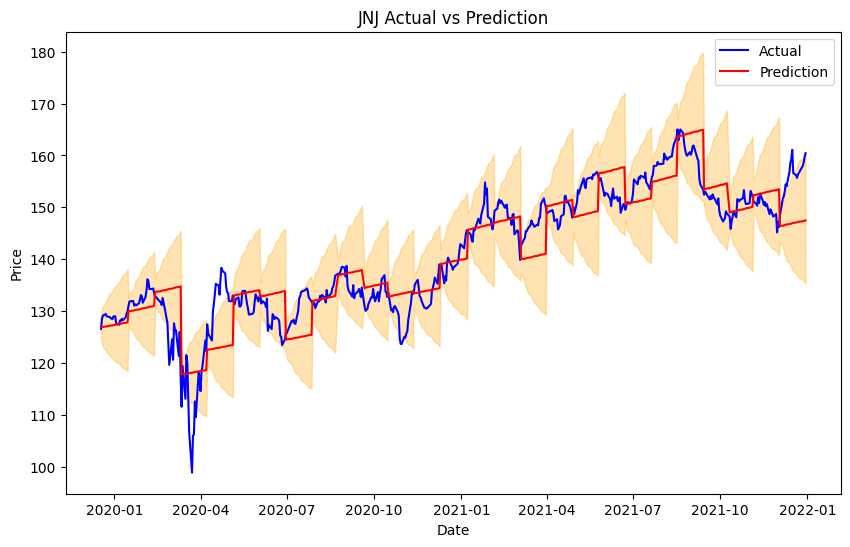

In [185]:
# Plot dei risultati
rand_ticker = random.choice(tickers)
plt.figure(figsize=(10, 6))
plt.plot(act_adj_close_df[max_train:].index, act_adj_close_df[max_train:][rand_ticker], label='Actual', color='blue')
plt.plot(ARIMA_prediction_df.index, ARIMA_prediction_df[rand_ticker], label='Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.fill_between(ARIMA_prediction_df.index, 
                      ARIMA_lower[rand_ticker], 
                      ARIMA_upper[rand_ticker], 
                      color='orange', alpha=0.3)
plt.title(f'{rand_ticker} Actual vs Prediction')
plt.legend()
plt.show()


In [16]:
import os

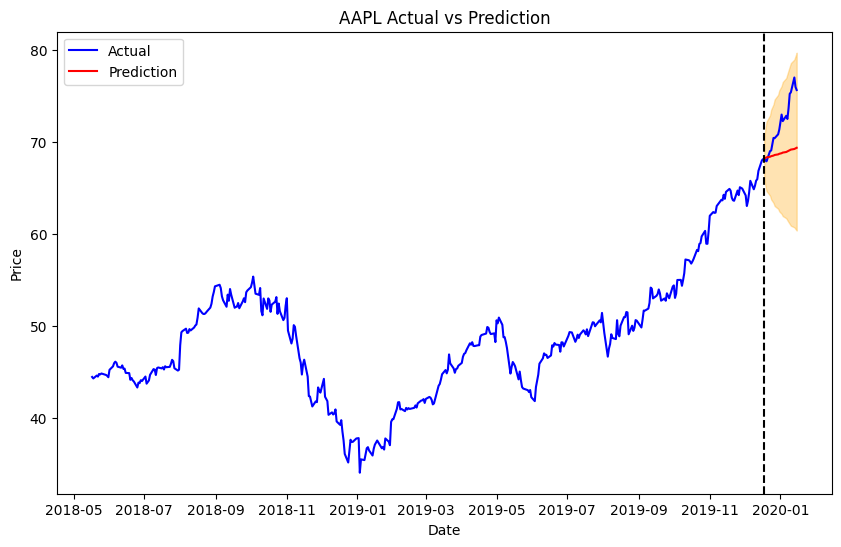

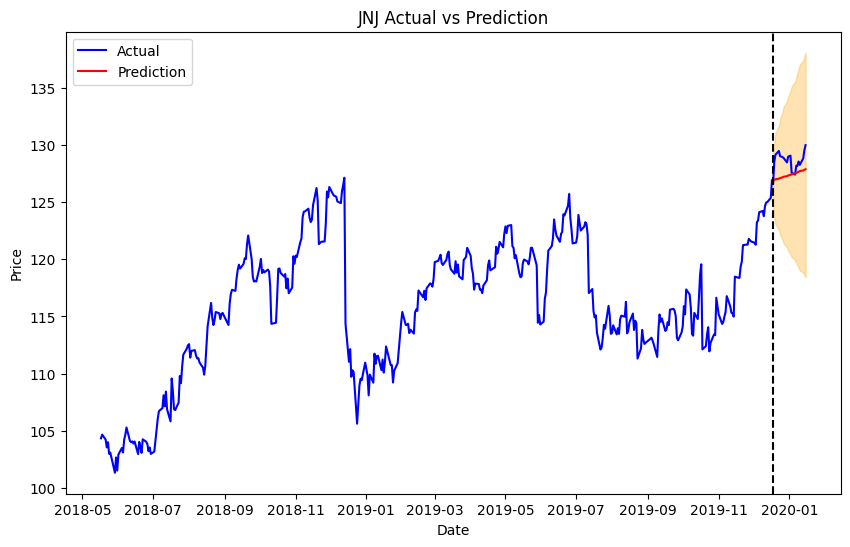

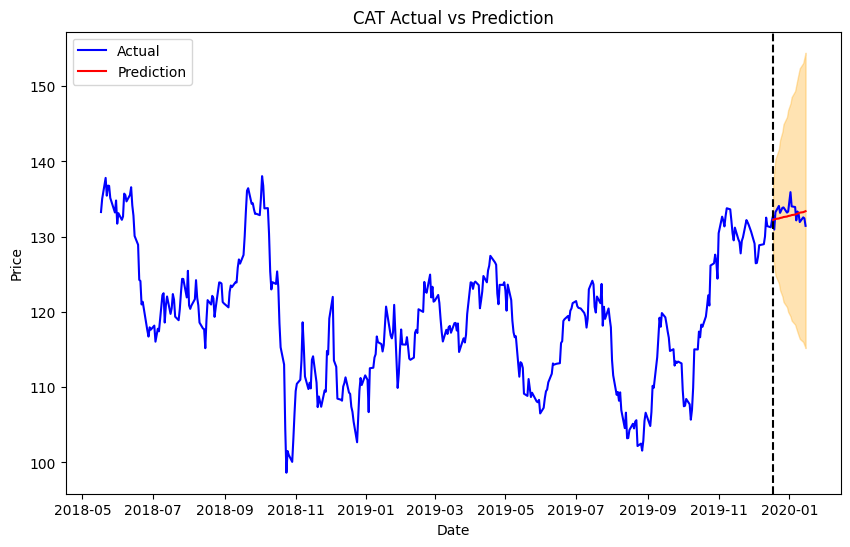

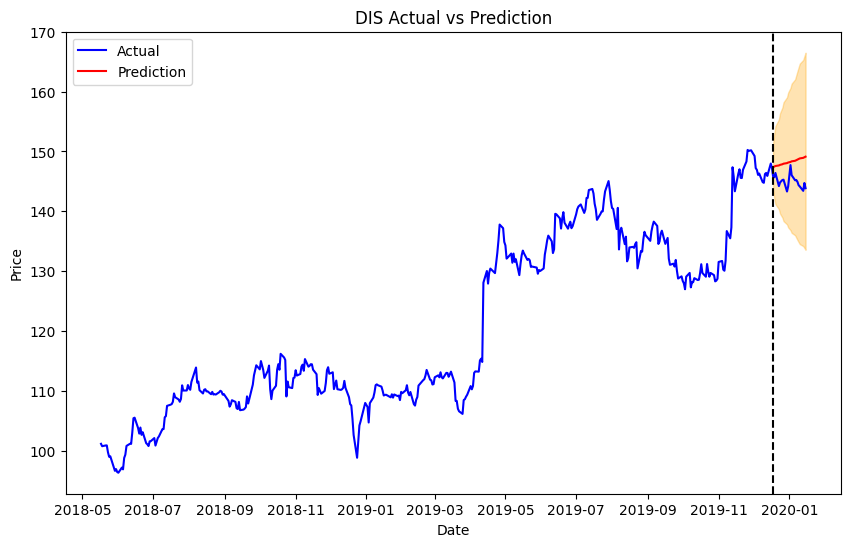

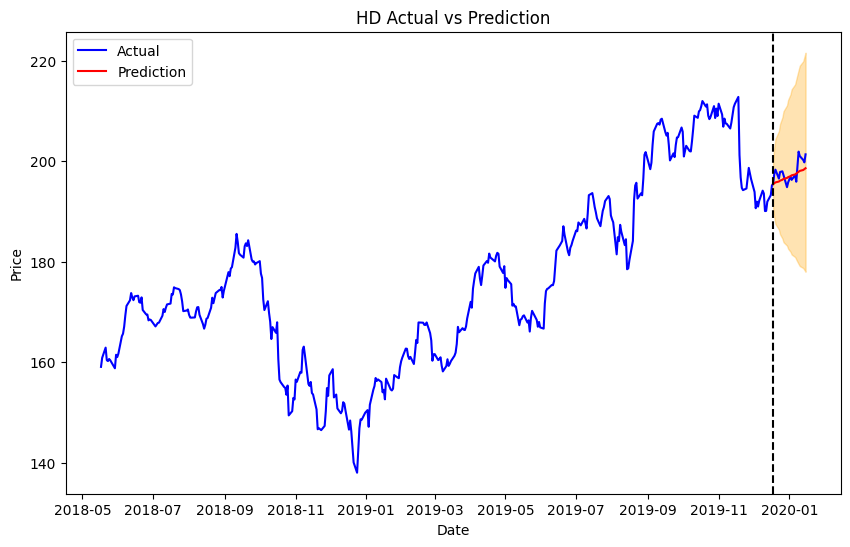

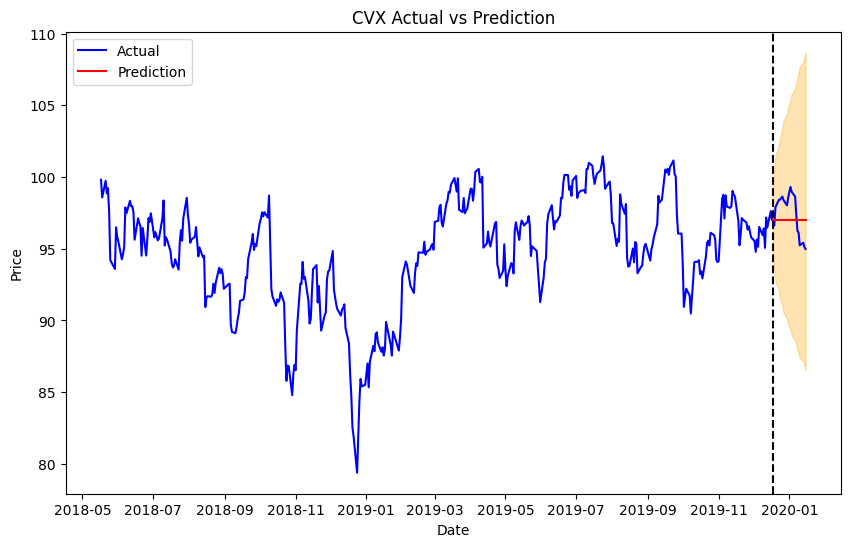

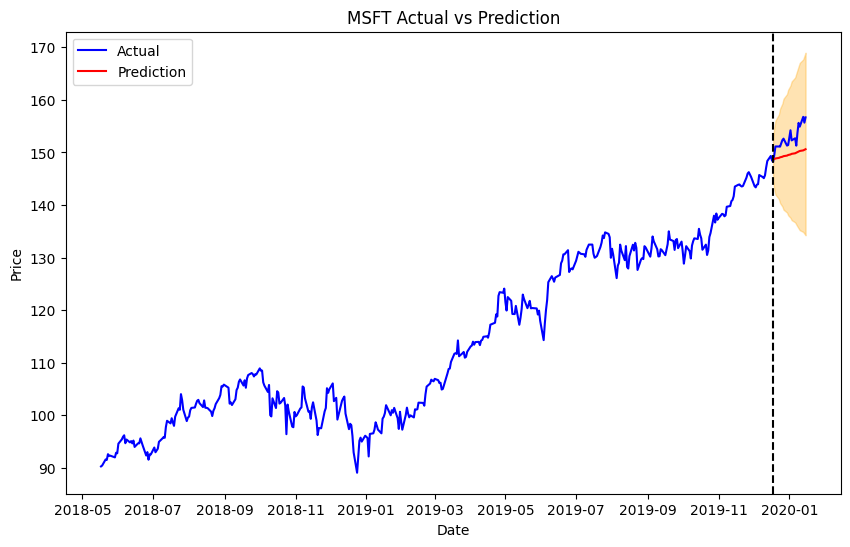

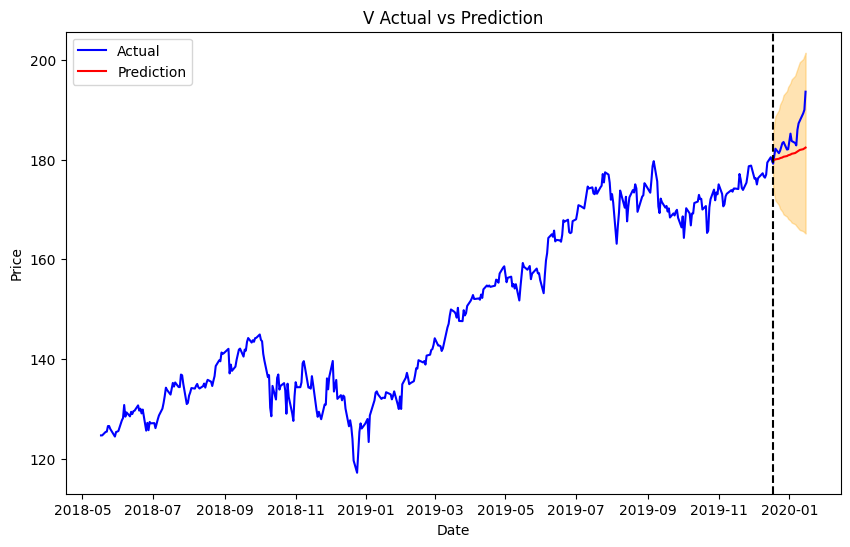

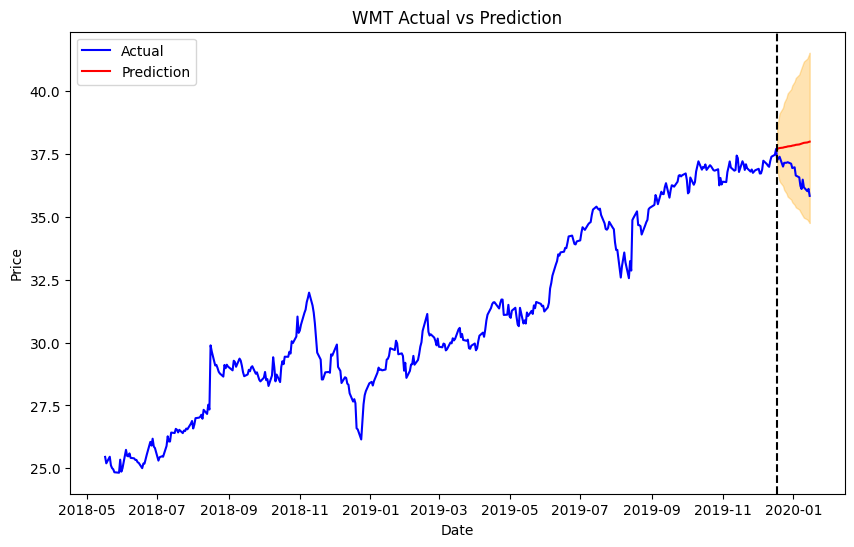

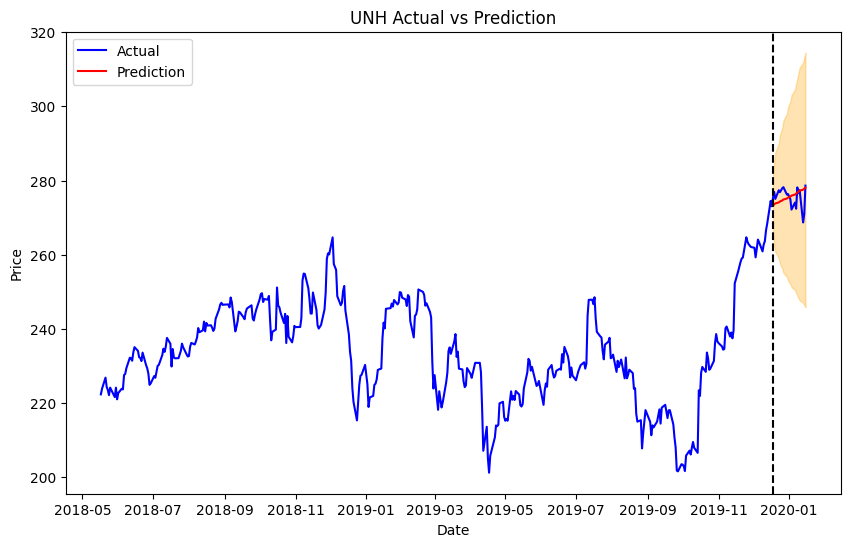

In [17]:
# Plot dei risultati
for ticker in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(act_adj_close_df[max_train - 400 : max_train + 19].index, act_adj_close_df[max_train - 400 : max_train + 19][ticker], label='Actual', color='blue')
    plt.plot(ARIMA_prediction_df[:19].index, ARIMA_prediction_df[ticker][:19], label='Prediction', color='red')
    plt.axvline(x=act_adj_close_df.index[max_train], c='black', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.fill_between(ARIMA_prediction_df[:19].index, 
                        ARIMA_lower[ticker][:19], 
                        ARIMA_upper[ticker][:19], 
                        color='orange', alpha=0.3)
    plt.title(f'{ticker} Actual vs Prediction')
    plt.legend()
    # Specificare la directory in cui salvare l'immagine
    save_dir = "C:/Users/fanta/OneDrive/Desktop/TesiFintech/ARIMA_multi_step"
    os.makedirs(save_dir, exist_ok=True)  # Creare la directory se non esiste

    # Salvare l'immagine
    file_path = os.path.join(save_dir, f'{ticker}_ARIMA_multi_step.png')
    plt.savefig(file_path)
    plt.show()

In [186]:
# valutazione del modello ARIMA (previsione a lungo termine)
for ticker in tickers:
    ARIMA_model_perf_df[ticker] = [MAE(act_adj_close_df[ticker][max_train:], ARIMA_prediction_df[ticker]), MSE(act_adj_close_df[ticker][max_train:], ARIMA_prediction_df[ticker]),
                                   RMSE(act_adj_close_df[ticker][max_train:], ARIMA_prediction_df[ticker]), MAPE(act_adj_close_df[ticker][max_train:], ARIMA_prediction_df[ticker])]

In [187]:
# stampo i risultati della valutazione
ARIMA_model_perf_df

AAPL        JNJ        CAT        DIS          HD        CVX  \
MAE    5.479860   3.913546   6.315579   6.853846    9.817706   3.711991   
MSE   50.335763  26.385357  72.037644  88.264308  191.248297  27.109144   
RMSE   7.094770   5.136668   8.487499   9.394909   13.829255   5.206644   
MAPE   0.051148   0.028144   0.041477   0.048575    0.040166   0.048412   

           MSFT          V       WMT         UNH  
MAE    7.534005   6.612662  1.214356   14.105063  
MSE   98.534380  83.007114  2.577413  364.043472  
RMSE   9.926448   9.110824  1.605432   19.079923  
MAPE   0.034967   0.034065  0.028390    0.044707

In [188]:
# perdita del modello durante il training
ARIMA_model_loss_df

AAPL       JNJ       CAT       DIS        HD       CVX      MSFT  \
MAE   0.051229  0.028152  0.041239  0.048072  0.039830  0.047329  0.035076   
MSE   0.004598  0.001424  0.003291  0.004609  0.003638  0.005007  0.002234   
RMSE  0.067807  0.037740  0.057368  0.067889  0.060317  0.070762  0.047262   
MAPE  0.011103  0.005712  0.008291  0.009768  0.007291  0.010957  0.006570   

             V       WMT       UNH  
MAE   0.033462  0.028483  0.044147  
MSE   0.002269  0.001427  0.004004  
RMSE  0.047632  0.037778  0.063276  
MAPE  0.006361  0.007595  0.007712

In [21]:
# trasformo il dataframe dei prezzi delle azione di ogni giorno nella differenza tra il giorno stesso e il giorno precedente
ARIMA_pred_daily_ret_df = ARIMA_prediction_df.pct_change()  # calcolo la differenza ripetto al giorno precedente
ARIMA_pred_daily_ret_df = ARIMA_pred_daily_ret_df.iloc[1:, :]
ARIMA_pred_daily_ret_df.head()

AAPL       JNJ       CAT       DIS        HD  CVX      MSFT  \
Date                                                                          
2019-12-19  0.000946  0.000050  0.000486  0.000657  0.000895  0.0  0.000738   
2019-12-20  0.000946  0.000434  0.000486  0.000657  0.000895  0.0  0.000736   
2019-12-23  0.000946  0.000434  0.000486  0.000657  0.000895  0.0  0.000735   
2019-12-24  0.000946  0.000434  0.000486  0.000657  0.000895  0.0  0.000735   
2019-12-26  0.000946  0.000434  0.000486  0.000657  0.000895  0.0  0.000735   

                   V      WMT      UNH  
Date                                    
2019-12-19  0.000505  0.00042  0.00096  
2019-12-20  0.000593  0.00042  0.00096  
2019-12-23  0.000660  0.00042  0.00096  
2019-12-24  0.000711  0.00042  0.00096  
2019-12-26  0.000749  0.00042  0.00096

### 3. Modello ARIMA one-step

In [22]:
# creazione dei dataframe dei risultati
ARIMA_onestep_prediction_df = pd.DataFrame(index=df.index[all_split:], columns=tickers)
ARIMA_onestep_model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE'], columns=tickers)
ARIMA_onestep_model_loss_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE'], columns=tickers)

In [23]:
# previsione one-step(viene valutato un giorno alla volta) su ogni ticker
for ticker in tickers:
    train_data, test_data = act_adj_close_sq_df[ticker][:all_split], act_adj_close_sq_df[ticker][all_split:]

     # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')

    model_one_step = create_model_auto_arima(train_set=train_data)

    history = [x for x in train_data.values]

    model_predictions = []

    for time_point in list(test_data.index):
        model_one_step.fit(history)
        output = model_one_step.predict(n_periods=1)
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data.loc[time_point]
        print(time_point)
        history.append(true_test_value)
    ARIMA_onestep_prediction_df[ticker] = model_predictions
    ARIMA_onestep_model_loss_df[ticker] = [MAE(test_data, model_predictions), MSE(test_data, model_predictions), RMSE(test_data, model_predictions), 
                                           MAPE(test_data, model_predictions)]

----------
AAPL fitting...
9 left
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13590.210, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13588.917, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13588.936, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13583.418, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13586.641, Time=0.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.657 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-0

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


----------
JNJ fitting...
8 left
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16293.240, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16293.487, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16293.615, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16289.721, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16291.875, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16293.849, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16293.665, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16293.327, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16291.938, Time=0.90 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-16289.623, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.601 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13319.741, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13318.352, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13318.325, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13319.706, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13316.460, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.121 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
202

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14612.236, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14612.274, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14612.322, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14608.166, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14610.968, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14610.657, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14609.032, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14607.895, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.005 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14919.907, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14919.993, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14908.904, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14918.380, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14919.015, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14916.787, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14909.767, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.577 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-03 00:00:00
2020-02

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14600.659, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14600.658, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14603.098, Time=0.13 sec


c:\Users\fanta\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\fanta\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14598.616, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.468 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00
2020-02-20 00:00:00
2020-02-21 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-26 00:00:00
2020-02-27 00:00:00
2020-02-28 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:0

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14228.397, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14229.378, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14229.529, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14223.517, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14230.138, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14227.019, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14226.670, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14229.097, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14228.966, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14225.025, Time=1.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14223.412, Time=0.21 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.200 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:0

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14087.917, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14088.578, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14071.018, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14094.772, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14085.800, Time=0.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14086.385, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14088.609, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14087.592, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14084.079, Time=1.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14082.662, Time=0.33 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.284 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
202

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15615.191, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15615.390, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15610.820, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15614.699, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15614.457, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15612.524, Time=1.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-15613.348, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.468 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-03 00:00:00
2020-02

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14200.271, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14200.238, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14192.067, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14198.254, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.184 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-18 00:00:00
2020-02-19 

C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2234684211.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto


In [24]:
# riporto i dati nella loro forma originale
ARIMA_onestep_prediction_df = np.exp(ARIMA_onestep_prediction_df)

In [25]:
# stampo gli ultimi valori predetti 
ARIMA_onestep_prediction_df.tail()

AAPL         JNJ         CAT         DIS          HD  \
Date                                                                     
2021-12-23  173.389546  156.354212  192.054098  151.379476  370.742098   
2021-12-27  174.021476  156.715022  195.903083  153.071640  372.288769   
2021-12-28  178.020862  157.952188  196.074156  152.451196  378.558384   
2021-12-29  176.993782  158.667863  196.302177  154.596475  380.825334   
2021-12-30  177.082587  159.735218  196.976939  154.472131  385.030572   

                   CVX        MSFT           V        WMT         UNH  
Date                                                                   
2021-12-23  105.623764  325.660858  213.807967  44.894884  479.229588  
2021-12-27  105.878448  327.663703  212.862606  44.808894  480.442116  
2021-12-28  108.043129  334.404963  213.556595  45.175527  484.439089  
2021-12-29  107.833923  334.467191  214.065492  45.800892  487.776224  
2021-12-30  107.279114  334.793414  214.206416  45.832719  490.337309

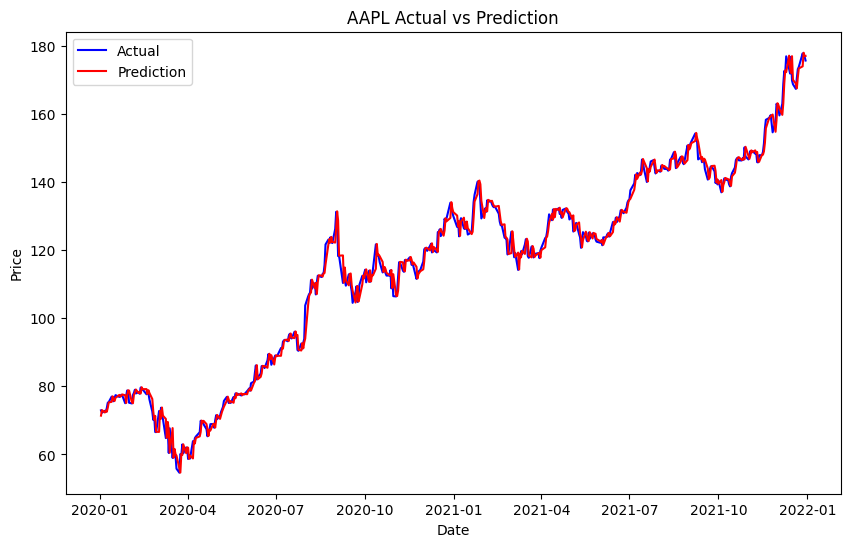

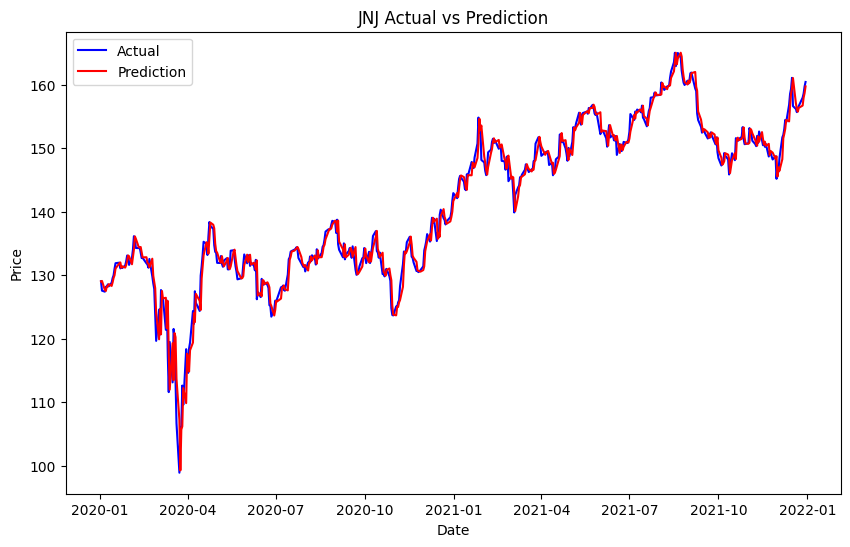

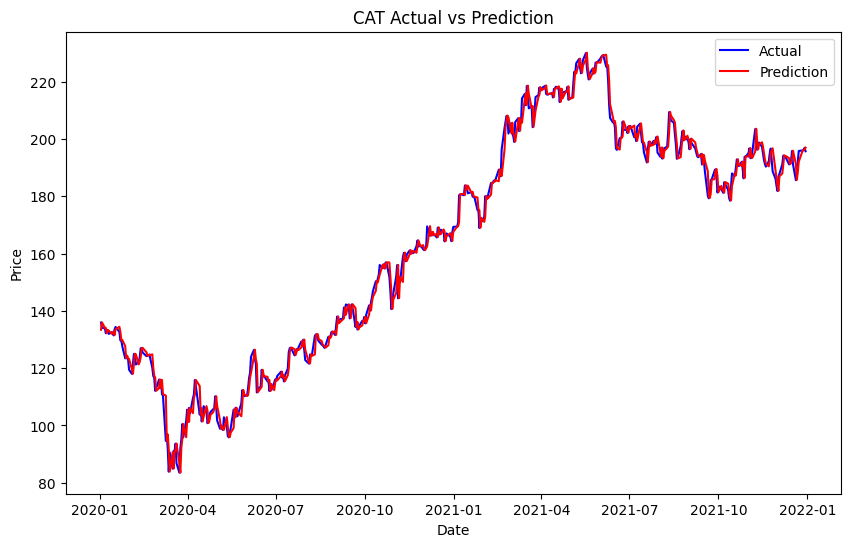

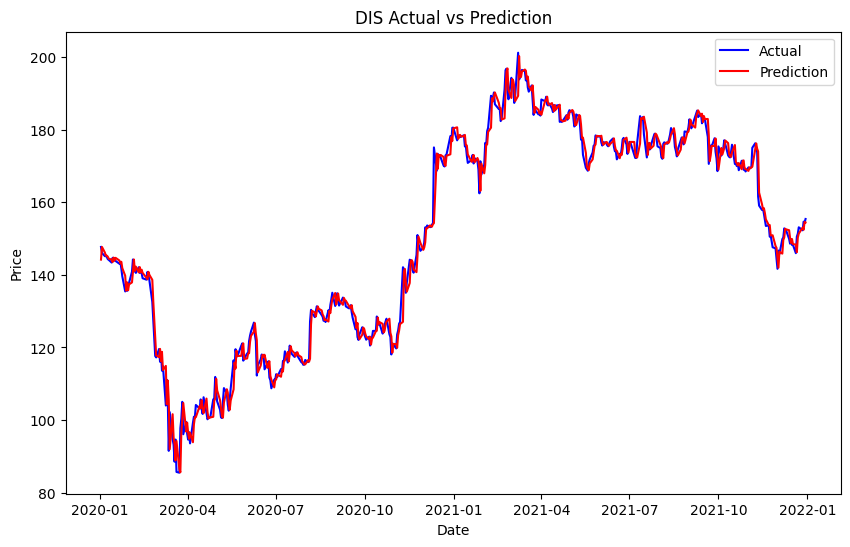

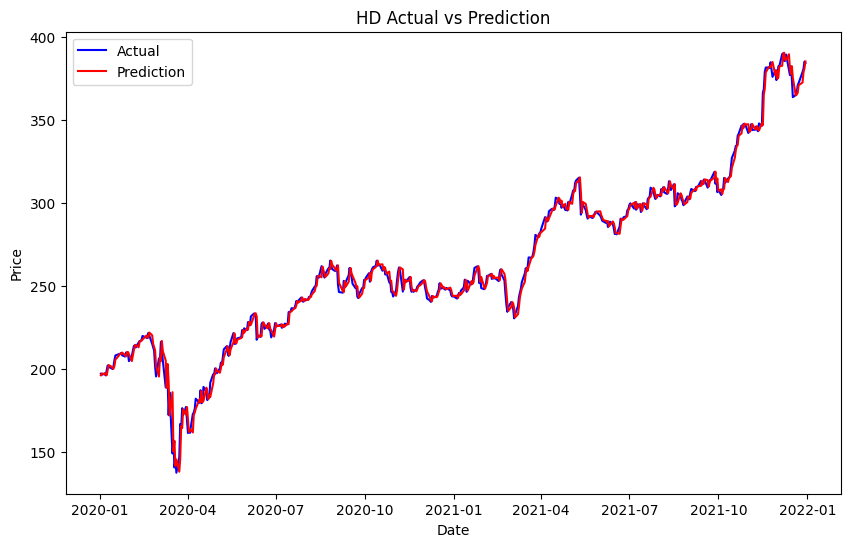

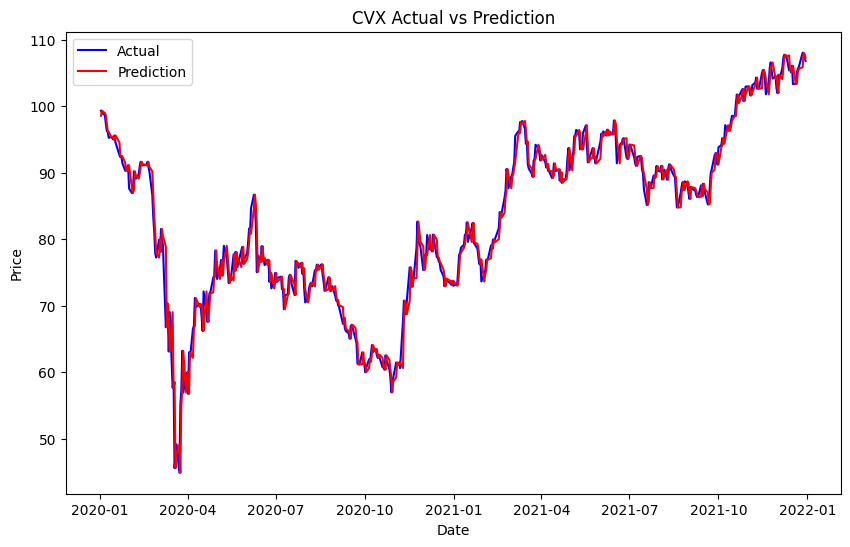

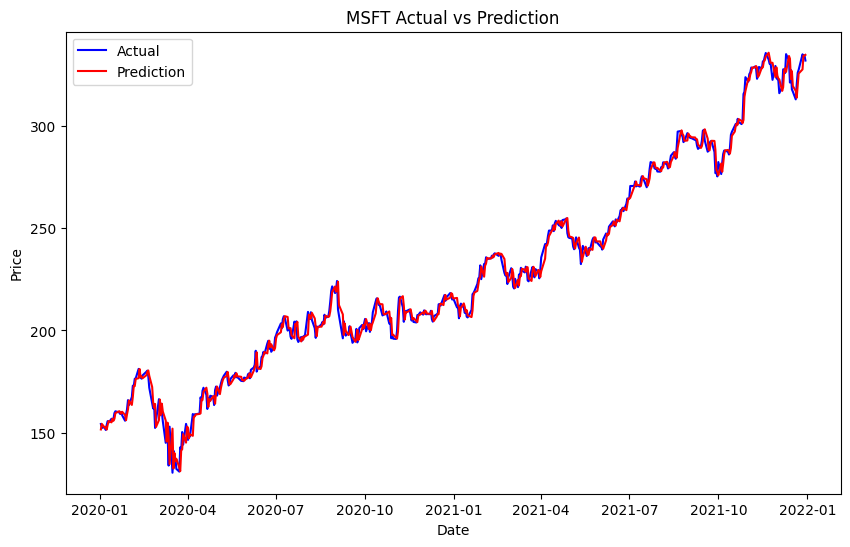

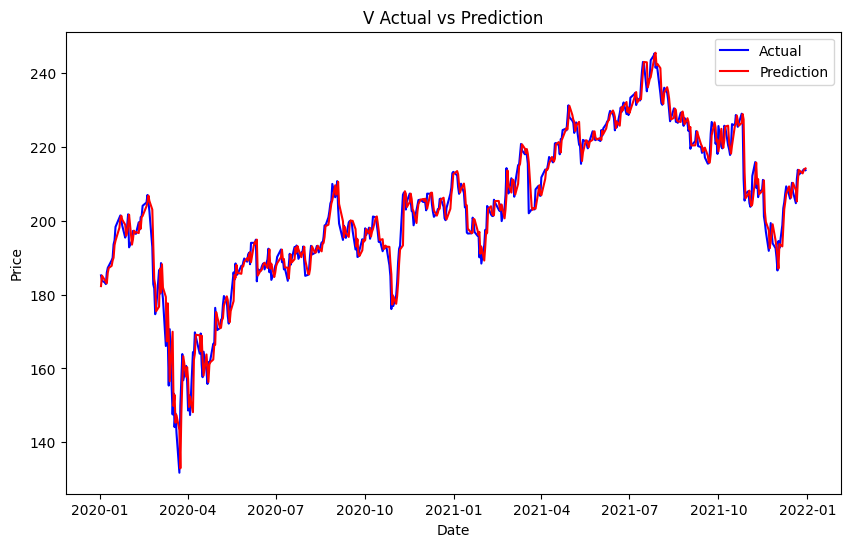

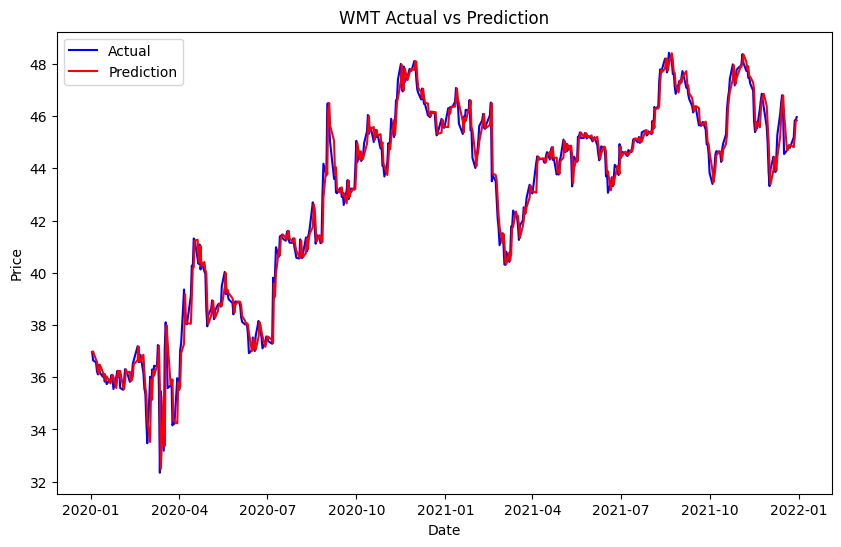

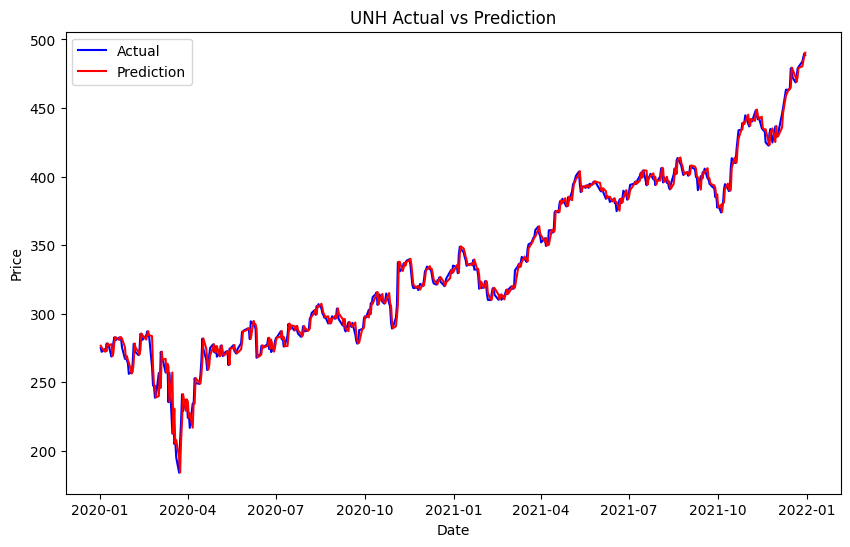

In [26]:
# Plot dei risultati
for rand_ticker in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(act_adj_close_df[all_split:].index, act_adj_close_df[all_split:][rand_ticker], label='Actual', color='blue')
    plt.plot(ARIMA_onestep_prediction_df.index, ARIMA_onestep_prediction_df[rand_ticker], label='Prediction', color='red')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{rand_ticker} Actual vs Prediction')
    plt.legend()
    # Specificare la directory in cui salvare l'immagine
    save_dir = "C:/Users/fanta/OneDrive/Desktop/TesiFintech/ARIMA_one_step"
    os.makedirs(save_dir, exist_ok=True)  # Creare la directory se non esiste

    # Salvare l'immagine
    file_path = os.path.join(save_dir, f'{rand_ticker}_ARIMA_one_step.png')
    plt.savefig(file_path)
    plt.show()

In [190]:
# valutazione del modello ARIMA (previsione one-step)
for ticker in tickers:
    ARIMA_onestep_model_perf_df[ticker] = [MAE(act_adj_close_df[ticker][all_split:], ARIMA_onestep_prediction_df[ticker]), MSE(act_adj_close_df[ticker][all_split:], ARIMA_onestep_prediction_df[ticker]),
                                   RMSE(act_adj_close_df[ticker][all_split:], ARIMA_onestep_prediction_df[ticker]), MAPE(act_adj_close_df[ticker][all_split:], ARIMA_onestep_prediction_df[ticker])]

In [191]:
# stampo i risultati della valutazione
ARIMA_onestep_model_perf_df

AAPL       JNJ        CAT        DIS         HD       CVX  \
MAE   1.746925  1.269230   2.413885   2.169174   3.117690  1.398030   
MSE   5.608029  3.541410  10.277362  10.098961  21.084781  4.156897   
RMSE  2.368128  1.881863   3.205833   3.177886   4.591817  2.038847   
MAPE  0.016306  0.009385   0.016193   0.015581   0.012964  0.018215   

           MSFT          V       WMT        UNH  
MAE    2.956788   2.776188  0.412512   4.273376  
MSE   16.428260  15.513771  0.383289  40.136438  
RMSE   4.053179   3.938753  0.619104   6.335332  
MAPE   0.014143   0.014397  0.009908   0.013977

In [29]:
# perdita del modello durante il training
ARIMA_onestep_model_loss_df

AAPL        JNJ        CAT        DIS         HD        CVX  \
MAE    0.016301   0.009382   0.016169   0.015588   0.012915   0.018156   
MSE  -17.597701 -19.534315 -20.657888 -19.990178 -25.358170 -15.056159   
RMSE        NaN        NaN        NaN        NaN        NaN        NaN   
MAPE   0.003538   0.001915   0.003270   0.003182   0.002373   0.004208   

           MSFT          V        WMT        UNH  
MAE    0.014134   0.014365   0.009918   0.013962  
MSE  -23.827280 -22.872221 -10.345736 -27.887546  
RMSE        NaN        NaN        NaN        NaN  
MAPE   0.002666   0.002736   0.002666   0.002453

In [30]:
# trasformo il dataframe dei prezzi delle azione di ogni giorno nella differenza tra il giorno stesso e il giorno precedente
ARIMA_pred_daily_ret_df = ARIMA_onestep_prediction_df.pct_change()  # calcolo la differenza ripetto al giorno precedente
ARIMA_pred_daily_ret_df = ARIMA_pred_daily_ret_df.iloc[1:, :]
ARIMA_pred_daily_ret_df.head()

AAPL       JNJ       CAT       DIS        HD       CVX  \
Date                                                                     
2020-01-03  0.022825  0.000558  0.019306  0.024139  0.005876  0.007634   
2020-01-06 -0.009726 -0.011149 -0.013890 -0.010468 -0.003590 -0.003459   
2020-01-07  0.007971 -0.001147 -0.000674 -0.005942  0.004947 -0.003388   
2020-01-08 -0.004705  0.005593 -0.013218  0.000160 -0.006879 -0.012770   
2020-01-09  0.016092 -0.000206  0.008885 -0.001996  0.015602 -0.011423   

                MSFT         V       WMT       UNH  
Date                                                
2020-01-03  0.017830  0.015658  0.000605 -0.005037  
2020-01-06 -0.011712 -0.006746 -0.008421 -0.010124  
2020-01-07  0.002421 -0.001954 -0.002317  0.006945  
2020-01-08 -0.008786 -0.002690 -0.008967 -0.006040  
2020-01-09  0.015197  0.015789 -0.003676  0.021092

### 4. Modello LSTM

In [31]:
# creazione del modello LSTM, con 3 livelli
def create_model(time_steps=100, neurons=100, activation='tanh', optimizer='adam', dropout_rate=0.2):
    model = Sequential(name="RNN_model")
    model.add(LSTM(units=neurons, activation=activation, return_sequences=False, input_shape=(time_steps, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=19))

    model.compile(optimizer=optimizer, loss='mse', metrics=[k.metrics.MeanAbsoluteError(), k.metrics.RootMeanSquaredError(), k.metrics.MeanAbsolutePercentageError()])
    
    return model

In [32]:
# creazione del dataset per il train
def dataset_train_creation(train_data, time_steps, num_out):
    x_data = []
    y_data = []
    for i in range(time_steps, len(train_data) - time_steps):
        x_data.append(train_data[i - time_steps : i, 0])
        y_data.append(train_data[i : i + num_out, 0])
    return np.array(x_data), np.array(y_data)

In [33]:
# creazione del dataset per il test
def dataset_test_creation(total_dataset, time_steps, num_out, train_data):
    test_data_adjusted = total_dataset[len(train_data) - time_steps:, :]
    x_data = []
    y_data = []
    for i in range(time_steps, len(test_data_adjusted), num_out):
        x_data.append(test_data_adjusted[i - time_steps: i, 0])
        y_data.append(test_data_adjusted[i : i + num_out, 0])
    return np.array(x_data), np.array(y_data)

In [34]:
max_train = 2508

In [35]:
# creazione dei dataframe dei risultati 
LSTM_prediction_df = pd.DataFrame(index=df.index[max_train:], columns=tickers)
LSTM_model_perf_df = pd.DataFrame(index=['MAE','MSE', 'RMSE', 'MAPE'], columns=tickers)
LSTM_model_loss_df = pd.DataFrame(index=['MAE','MSE', 'RMSE', 'MAPE'], columns=tickers)

In [36]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
# normalizzazione dell'intero insieme dei dati
scaler = MinMaxScaler(feature_range=(0,1))

# previsione LSTM fatta su ogni ticker
for ticker in tickers:
    data_scaled = scaler.fit_transform(np.array(act_adj_close_df[ticker]).reshape(-1, 1))   # normalizzo i dati 

    train, test = data_scaled[:all_split], data_scaled[all_split:]                          # divido in train set e test set 

    train_data = data_scaled[0: max_train, :]
    test_data = data_scaled[max_train: len(data_scaled), :]

    time_steps = 100
    num_out = 19

    x_train, y_train = dataset_train_creation(train_data=train_data, time_steps=time_steps, num_out=num_out)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    x_test, y_test = dataset_test_creation(total_dataset=data_scaled, time_steps=time_steps, num_out=num_out, train_data=train_data)
    
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    
    # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')

    model = create_model(time_steps=time_steps)

    model.summary()

    model.fit(x_train, y_train,
              epochs=150,
              batch_size=32,
              shuffle=False,
              validation_split=0.2,
              verbose=2)    
    
    scaled_preds = model.predict(x_test)
    test_preds = scaler.inverse_transform(scaled_preds)
    test_preds = np.array(test_preds).reshape(-1)
    LSTM_prediction_df[ticker] = test_preds
    score = model.evaluate(x_test, y_test, verbose=0) 
    LSTM_model_loss_df[ticker] = [score[1], score[0], score[2], score[3]]
    
    

----------
AAPL fitting...
9 left
Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 19)                1919      
                                                                 
Total params: 42,719
Trainable params: 42,719
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
58/58 - 9s - loss: 0.0011 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0328 - mean_absolute_percentage_error: 33.5595 - val_loss: 0.0030 - val_mean_absolute_error: 0.0482 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 20.7508 - 

In [38]:
LSTM_prediction_df.head()

AAPL         JNJ         CAT         DIS          HD  \
Date                                                                    
2019-12-18  64.550888  126.360573  136.938766  141.743820  188.834763   
2019-12-19  64.747353  126.410568  137.114883  141.368698  188.804016   
2019-12-20  64.394409  126.477646  136.230194  141.013870  188.905380   
2019-12-23  64.589966  126.508141  136.788895  140.522308  189.141464   
2019-12-24  64.758522  126.585999  135.960770  140.129593  189.114944   

                  CVX        MSFT           V        WMT         UNH  
Date                                                                  
2019-12-18  97.777428  139.853271  170.666748  35.348316  253.034698  
2019-12-19  97.611305  140.159409  170.783203  35.331791  254.001953  
2019-12-20  97.621384  140.642914  171.199341  35.200901  254.422134  
2019-12-23  97.320129  140.605118  171.603622  35.186054  253.583649  
2019-12-24  97.241455  141.477844  171.797043  35.129330  254.912262

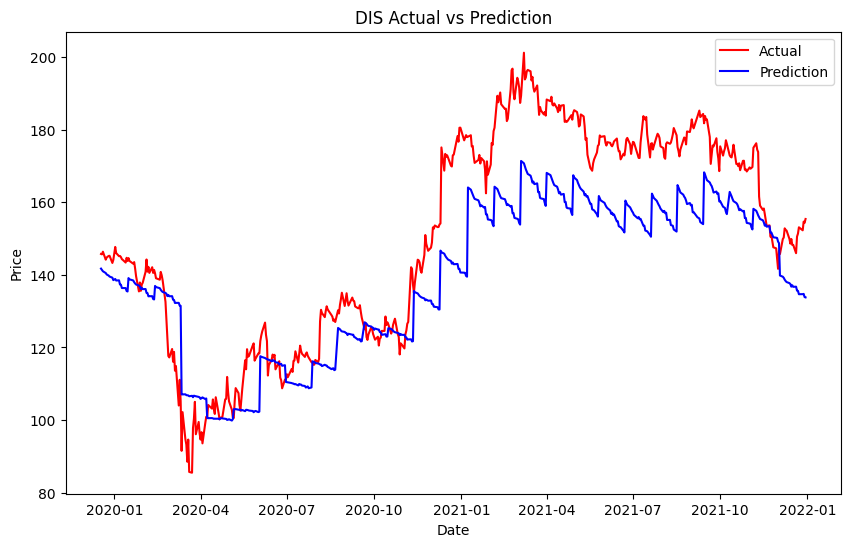

In [39]:
# Plot dei risultati 
rand_ticker = random.choice(tickers)
plt.figure(figsize=(10, 6))
plt.plot(act_adj_close_df.index[max_train:], act_adj_close_df[rand_ticker][max_train:], label='Actual', color='red')
plt.plot(LSTM_prediction_df.index, LSTM_prediction_df[rand_ticker], label='Prediction', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{rand_ticker} Actual vs Prediction')
plt.legend()
plt.show()

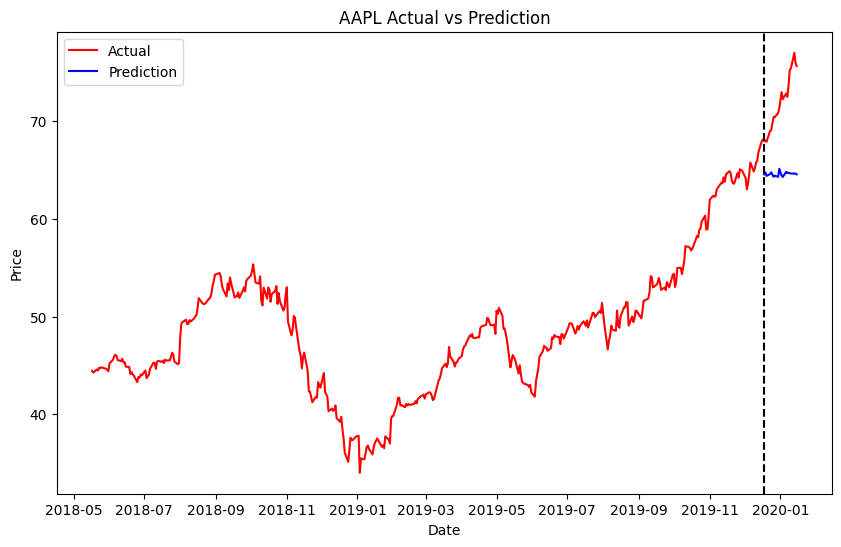

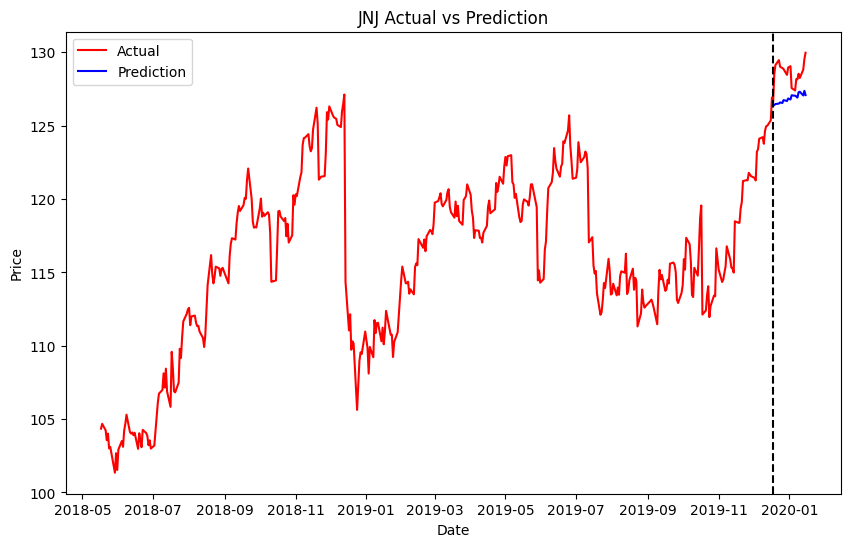

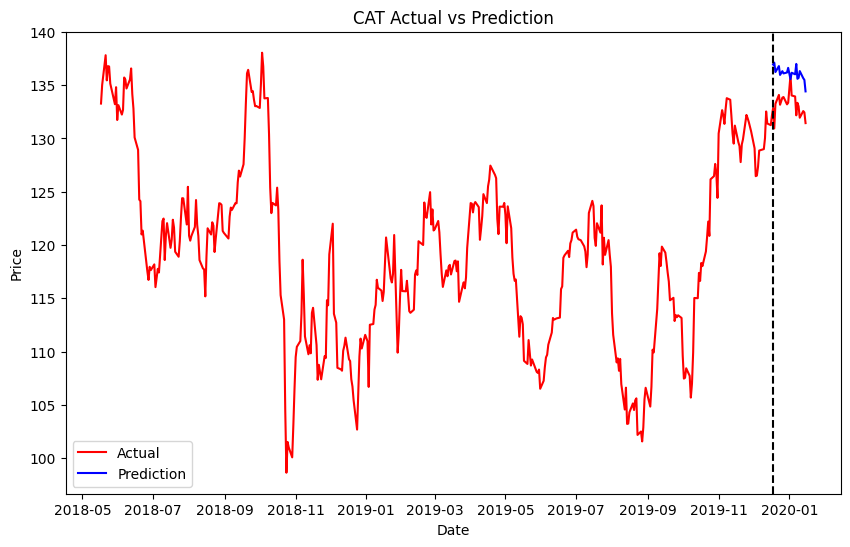

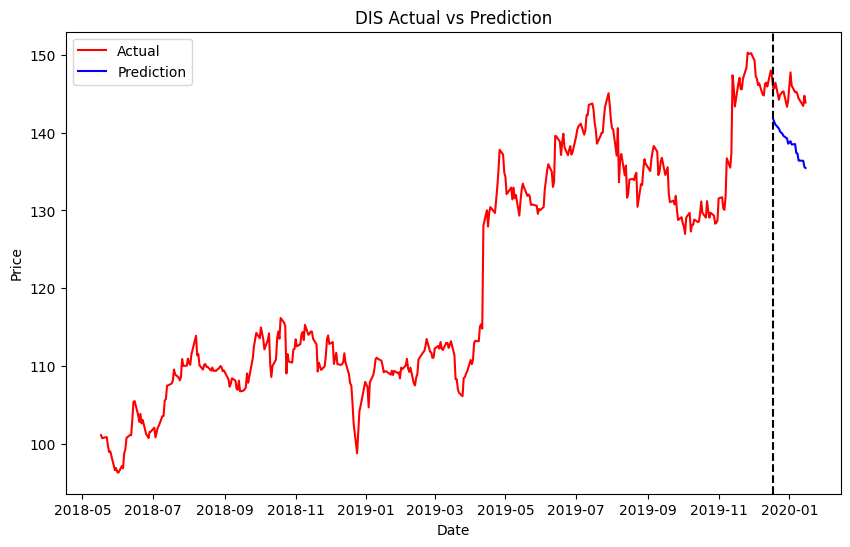

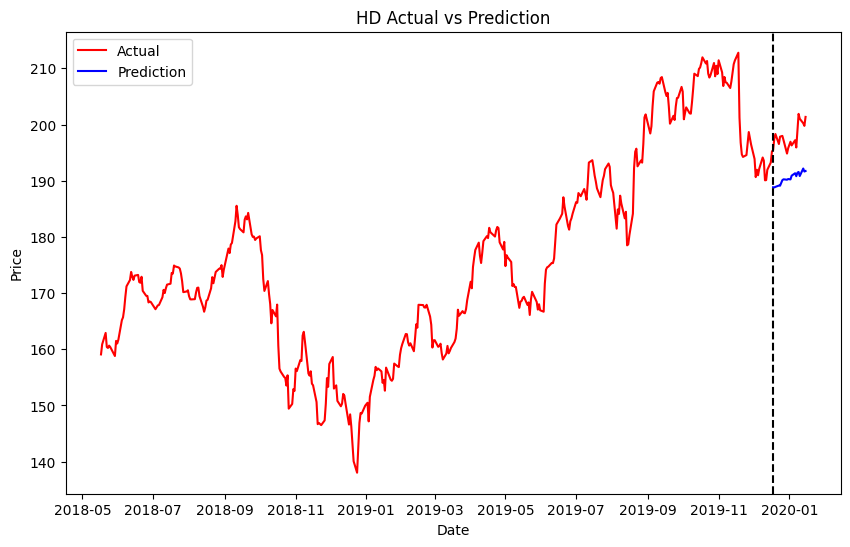

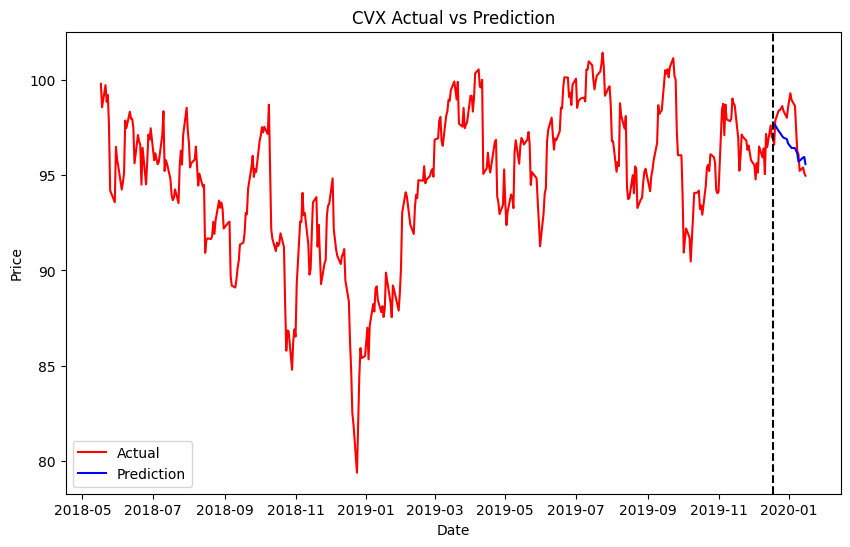

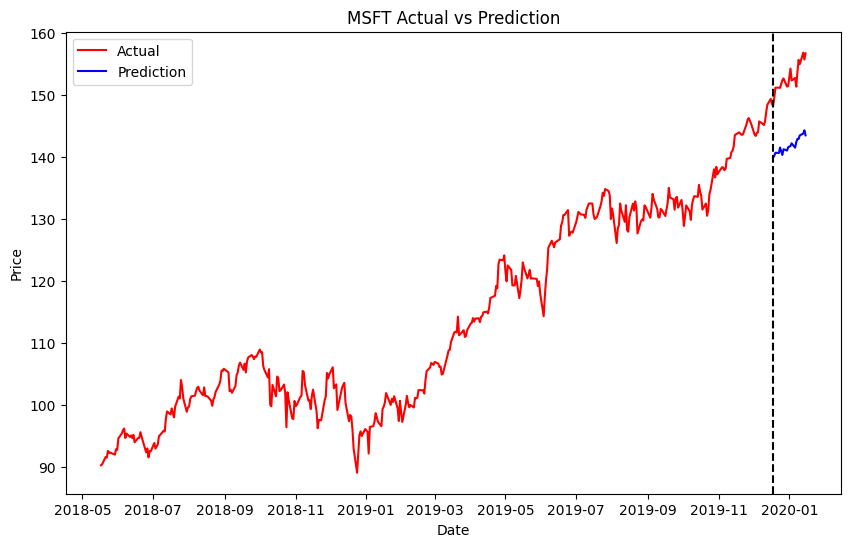

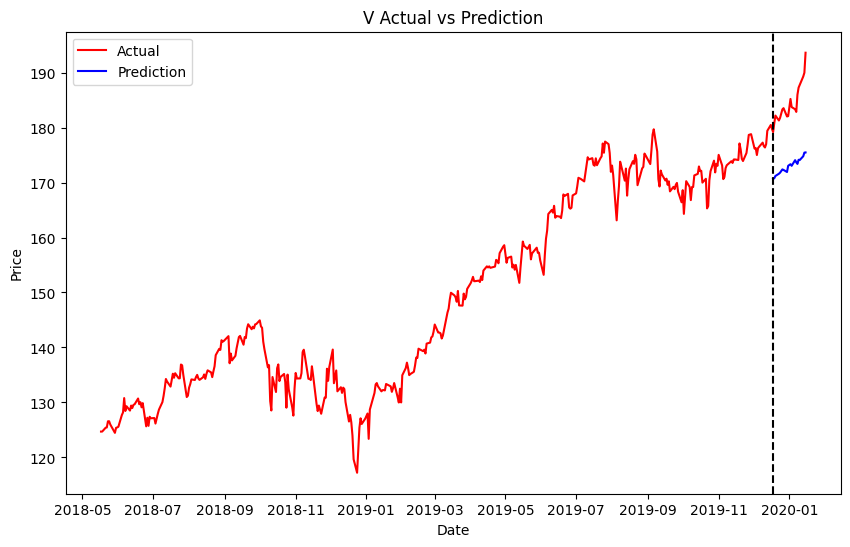

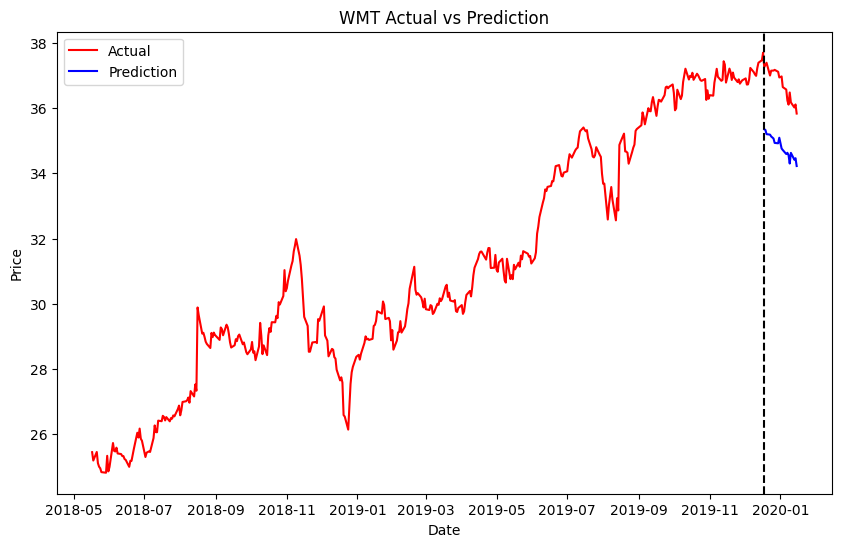

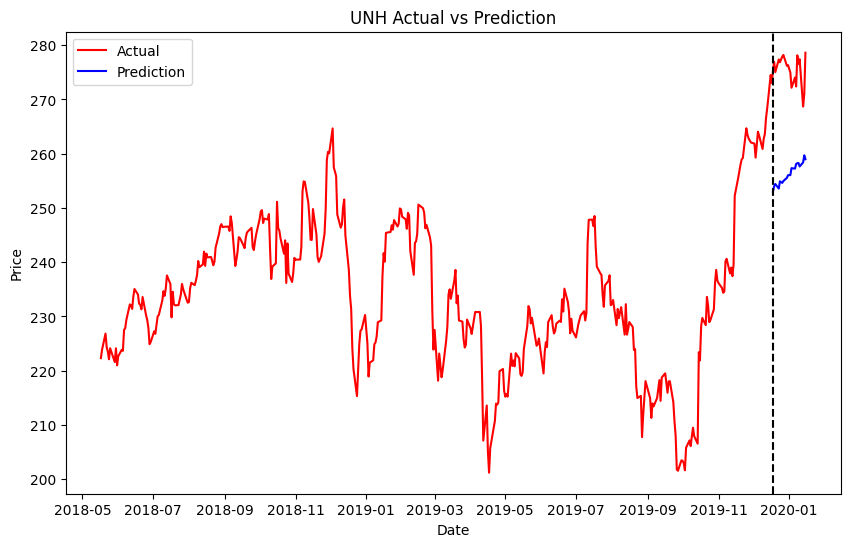

In [40]:
for rand_ticker in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(act_adj_close_df[max_train - 400 : max_train + 19].index, act_adj_close_df[rand_ticker][max_train - 400 : max_train + 19], label='Actual', color='red')
    plt.plot(LSTM_prediction_df[:19].index, LSTM_prediction_df[rand_ticker][:19], label='Prediction', color='blue')
    plt.axvline(x=act_adj_close_df.index[max_train], c='black', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{rand_ticker} Actual vs Prediction')
    plt.legend()
    # Specificare la directory in cui salvare l'immagine
    save_dir = "C:/Users/fanta/OneDrive/Desktop/TesiFintech/LSTM_multi_step"
    os.makedirs(save_dir, exist_ok=True)  # Creare la directory se non esiste

    # Salvare l'immagine
    file_path = os.path.join(save_dir, f'{rand_ticker}_LSTM_multi_step.png')
    plt.savefig(file_path)
    plt.show()

In [193]:
# valutazione del modello LSTM
for ticker in tickers: 
    LSTM_model_perf_df[ticker] = [MAE(act_adj_close_df[ticker][max_train:], LSTM_prediction_df[ticker]), MSE(act_adj_close_df[ticker][max_train:], LSTM_prediction_df[ticker]), 
                                  RMSE(act_adj_close_df[ticker][max_train:], LSTM_prediction_df[ticker]), MAPE(act_adj_close_df[ticker][max_train:], LSTM_prediction_df[ticker])]

In [194]:
LSTM_model_perf_df

AAPL        JNJ         CAT         DIS          HD        CVX  \
MAE    20.496843   3.993394   13.688673   13.481309   19.889259   3.916123   
MSE   550.814753  28.008869  303.232424  266.307605  571.376754  28.322448   
RMSE   23.469443   5.292341   17.413570   16.318934   23.903488   5.321884   
MAPE    0.165244   0.028714    0.080188    0.084958    0.074382   0.051338   

            MSFT           V        WMT          UNH  
MAE    26.234506   12.766570   4.773691    42.902279  
MSE   896.607142  206.773322  26.099015  2545.331802  
RMSE   29.943399   14.379615   5.108719    50.451281  
MAPE    0.109631    0.062481   0.109311     0.120231

In [43]:
LSTM_model_loss_df

AAPL       JNJ        CAT        DIS        HD        CVX  \
MAE    0.119150  0.031419   0.070257   0.076685  0.053672   0.056425   
MSE    0.018613  0.001734   0.007988   0.008617  0.004161   0.005880   
RMSE   0.136430  0.041639   0.089375   0.092826  0.064505   0.076680   
MAPE  17.392117  3.975903  10.365121  10.230114  8.063001  12.327022   

           MSFT         V        WMT        UNH  
MAE    0.082457  0.055368   0.130243   0.091825  
MSE    0.008857  0.003889   0.019428   0.011660  
RMSE   0.094114  0.062364   0.139383   0.107983  
MAPE  11.884046  6.744253  15.015965  12.875079

In [44]:
# trasformo il dataframe dei prezzi delle azione di ogni giorno nella differenza tra il giorno stesso e il giorno precedente
LSTM_pred_daily_ret_df = LSTM_prediction_df.pct_change()  # calcolo la differenza ripetto al giorno precedente
LSTM_pred_daily_ret_df = LSTM_pred_daily_ret_df.iloc[1:, :]
LSTM_pred_daily_ret_df.head()

AAPL       JNJ       CAT       DIS        HD       CVX  \
Date                                                                     
2019-12-19  0.003044  0.000396  0.001286 -0.002647 -0.000163 -0.001699   
2019-12-20 -0.005451  0.000531 -0.006452 -0.002510  0.000537  0.000103   
2019-12-23  0.003037  0.000241  0.004101 -0.003486  0.001250 -0.003086   
2019-12-24  0.002610  0.000615 -0.006054 -0.002795 -0.000140 -0.000808   
2019-12-26 -0.006996 -0.000275  0.002588 -0.002096  0.005246 -0.001897   

                MSFT         V       WMT       UNH  
Date                                                
2019-12-19  0.002189  0.000682 -0.000467  0.003823  
2019-12-20  0.003450  0.002437 -0.003705  0.001654  
2019-12-23 -0.000269  0.002361 -0.000422 -0.003296  
2019-12-24  0.006207  0.001127 -0.001612  0.005239  
2019-12-26 -0.008403  0.003462 -0.001761 -0.001121

### 5. Modello LSTM one-step

In [45]:
# creazione del modello LSTM, con 3 livelli
def create_model_one_step(time_steps=100, neurons=100, activation='tanh', optimizer='adam', dropout_rate=0.0):
    model = Sequential(name="RNN_model")
    model.add(LSTM(units=neurons, activation=activation, return_sequences=False, input_shape=(time_steps, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mse', metrics=[k.metrics.MeanAbsoluteError(), k.metrics.RootMeanSquaredError(), k.metrics.MeanAbsolutePercentageError()])

    return model

In [46]:
# creazione del dataset per il train
def dataset_train_creation_one_step(train_data, time_steps):
    x_data = []
    y_data = []
    for i in range(time_steps, len(train_data)):
        x_data.append(train_data[i - time_steps: i, 0])
        y_data.append(train_data[i, 0])
    return np.array(x_data), np.array(y_data)

In [47]:
# creazione del dataset per il test
def dataset_test_creation_one_step(total_dataset, time_steps, train_data):
    test_data_adjusted = total_dataset[len(train_data) - time_steps:, :]
    x_data = []
    for i in range(time_steps, len(test_data_adjusted)):
        x_data.append(test_data_adjusted[i - time_steps: i, 0])
    return np.array(x_data)

In [48]:
# creazione dei dataframe dei risultati 
LSTM_one_step_prediction_df = pd.DataFrame(index=df.index[all_split:], columns=tickers)
LSTM_one_step_model_perf_df = pd.DataFrame(index=['MAE','MSE', 'RMSE', 'MAPE'], columns=tickers)
LSTM_one_step_model_loss_df = pd.DataFrame(index=['MAE','MSE', 'RMSE', 'MAPE'], columns=tickers)

In [49]:
# normalizzazione dell'intero insieme dei dati
scaler = MinMaxScaler(feature_range=(0,1))

# previsione LSTM fatta su ogni ticker
for ticker in tickers:
    data_scaled = scaler.fit_transform(np.array(act_adj_close_df[ticker]).reshape(-1, 1))   # normalizzo i dati 

    train, test = data_scaled[:all_split], data_scaled[all_split:]                          # divido in train set e test set 

    train_data = data_scaled[0: len(train), :]
    test_data = data_scaled[len(train): len(data_scaled), :]

    time_steps = 100

    x_train, y_train = dataset_train_creation_one_step(train_data=train_data, time_steps=time_steps)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    x_test = dataset_test_creation_one_step(total_dataset=data_scaled, time_steps=time_steps, train_data=train_data)
    y_test = np.array(test_data)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')

    model_one_step = create_model_one_step(time_steps=time_steps)

    model_one_step.summary()

    model_one_step.fit(x_train, y_train,
              epochs=100,
              batch_size=24,
              shuffle=False,
              validation_split=0.2,
              verbose=2)    


    scaled_preds = model_one_step.predict(x_test)
    test_preds = scaler.inverse_transform(scaled_preds)
    LSTM_one_step_prediction_df[ticker] = test_preds
    score = model_one_step.evaluate(x_test, y_test, verbose=0) 
    LSTM_one_step_model_loss_df[ticker] = [score[1], score[0], score[2], score[3]]

----------
AAPL fitting...
9 left
Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100)               40800     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
81/81 - 5s - loss: 1.0699e-04 - mean_absolute_error: 0.0082 - root_mean_squared_error: 0.0103 - mean_absolute_percentage_error: 14.2770 - val_loss: 0.0012 - val_mean_absolute_error: 0.0255 - val_root_mean_squared_error: 0.0346 - val_mean_absolute_percentage_error: 9.5017

In [50]:
LSTM_one_step_prediction_df.head()

AAPL         JNJ         CAT         DIS          HD  \
Date                                                                    
2020-01-02  66.503136  128.878510  135.221420  137.862244  194.847122   
2020-01-03  67.628342  129.029495  138.074951  141.658920  196.022446   
2020-01-06  67.453697  127.846146  135.519241  139.090225  196.068832   
2020-01-07  67.689240  127.520340  135.662766  138.319611  196.623016   
2020-01-08  67.518440  128.136948  133.784760  138.557983  195.804565   

                  CVX        MSFT           V        WMT         UNH  
Date                                                                  
2020-01-02  98.880707  156.714584  188.098999  37.512161  282.954559  
2020-01-03  99.594879  158.903900  190.932556  37.570786  281.860382  
2020-01-06  99.066284  158.178802  190.201996  37.215401  279.469971  
2020-01-07  98.767212  158.167282  189.608551  37.148529  280.121033  
2020-01-08  97.424690  157.052811  188.984787  36.802711  279.375336

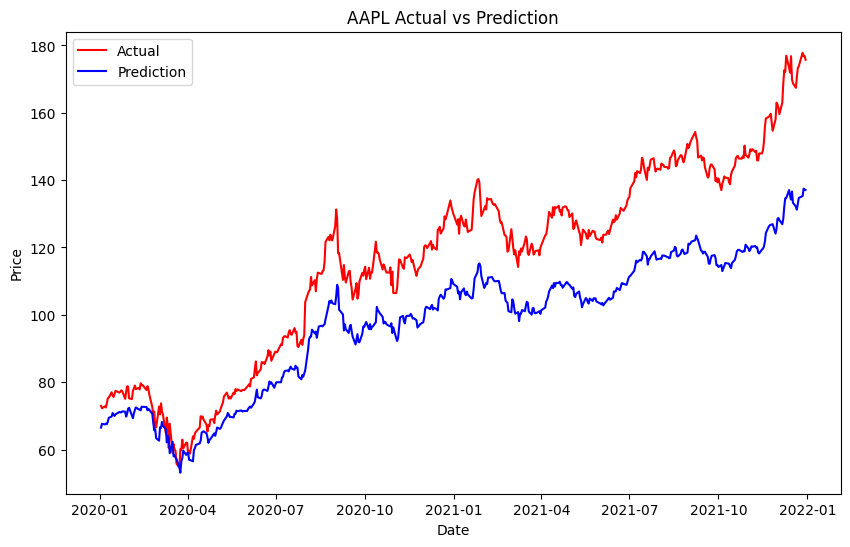

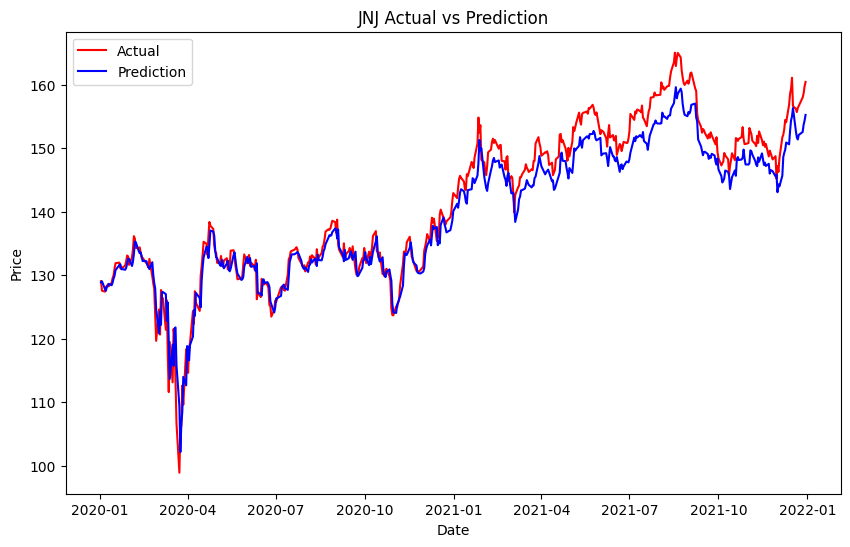

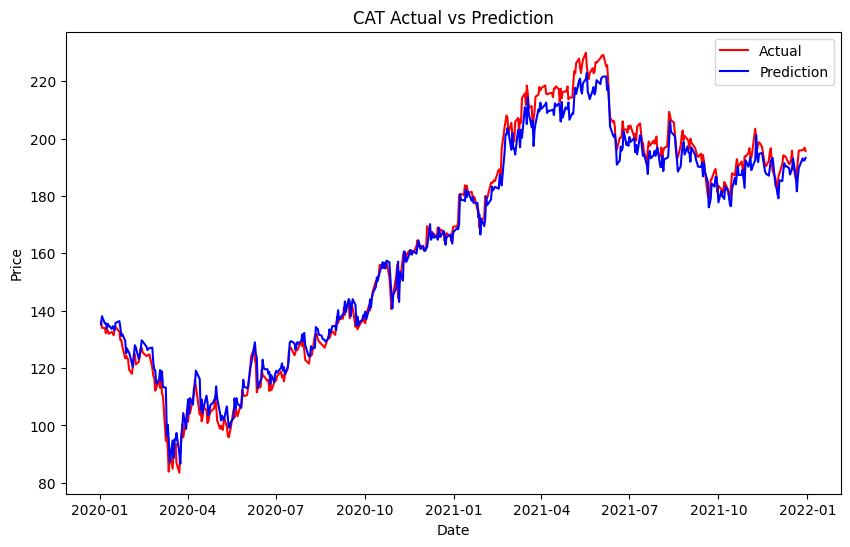

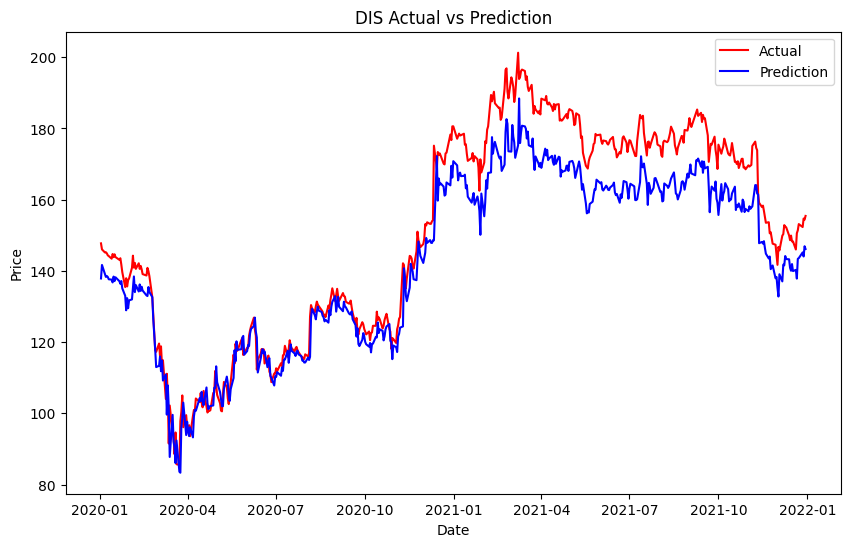

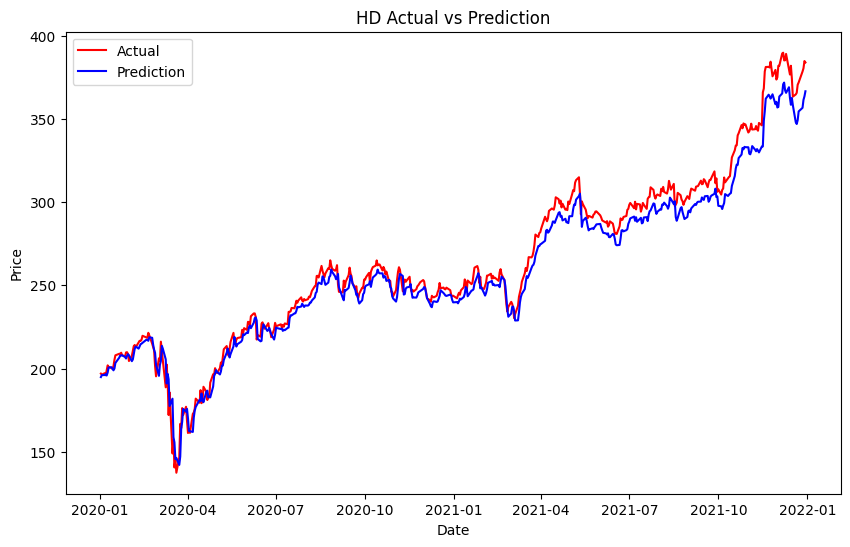

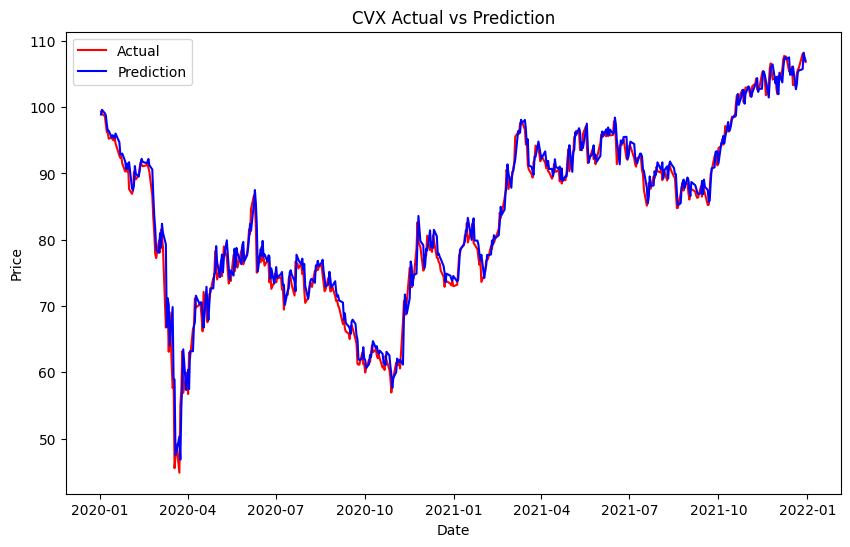

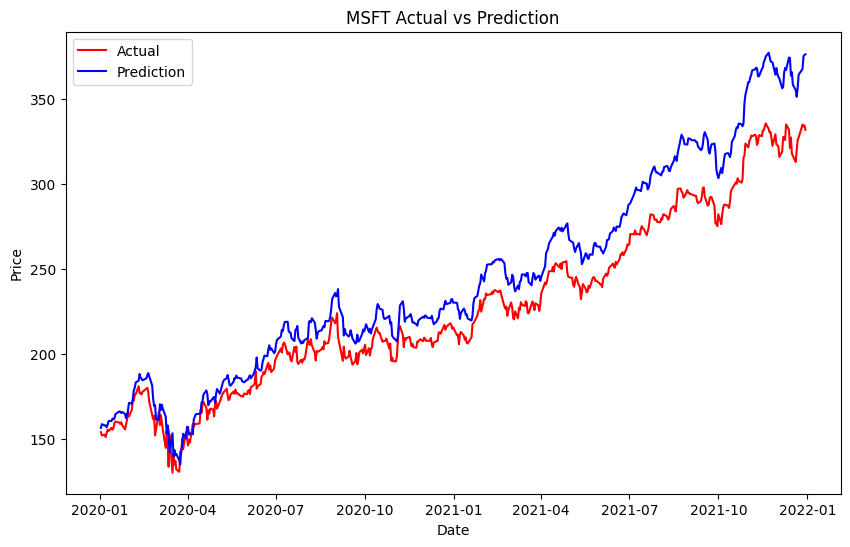

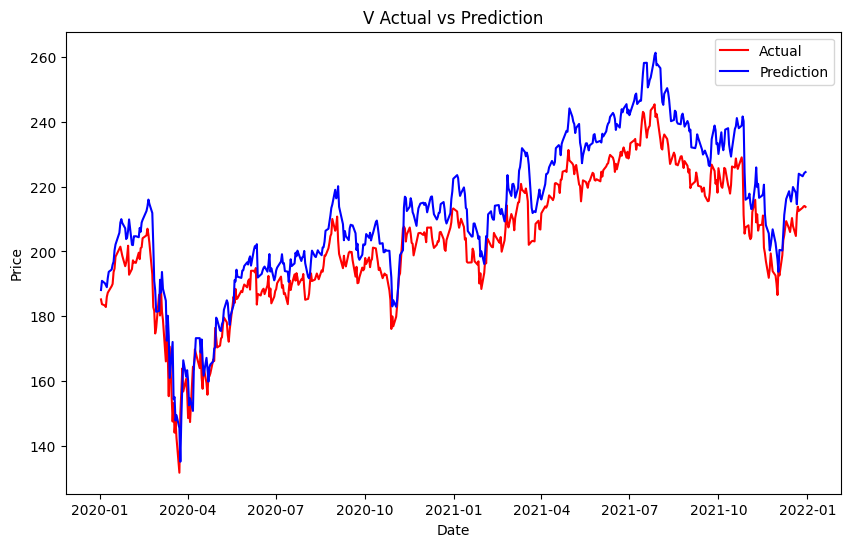

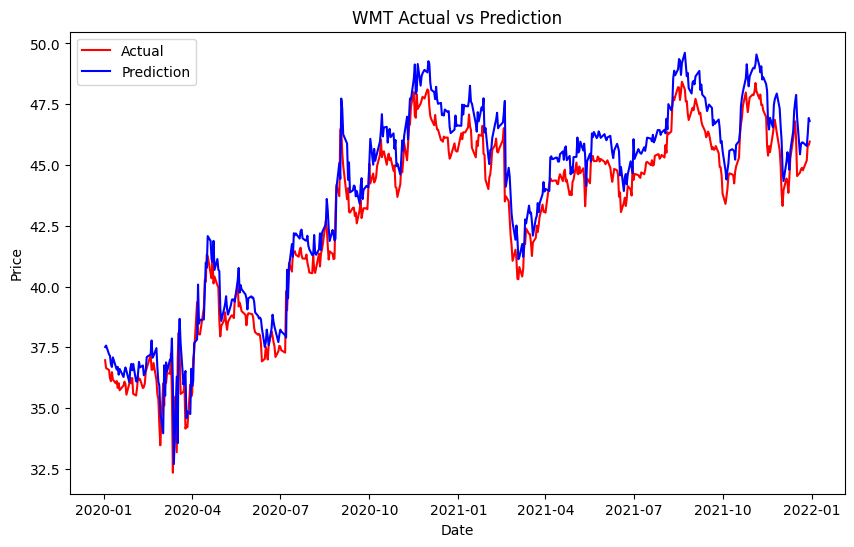

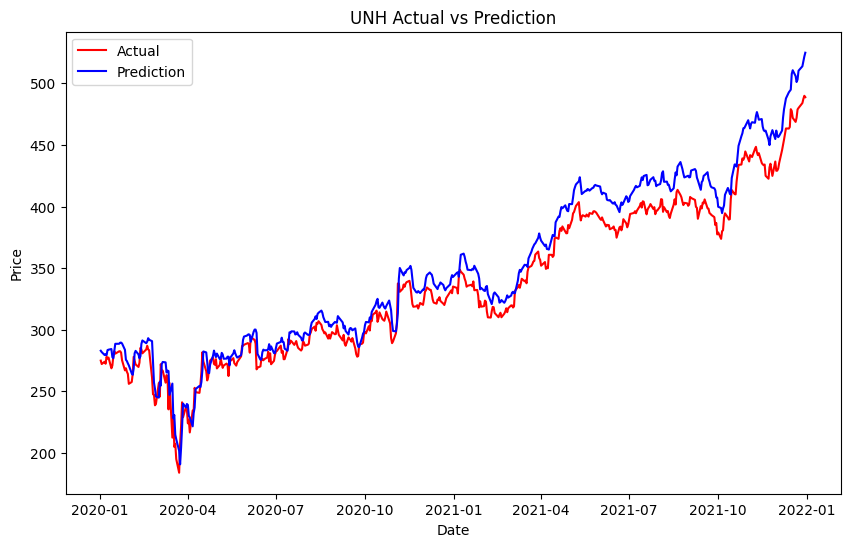

In [51]:
for rand_ticker in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(act_adj_close_df.index[all_split:], act_adj_close_df[rand_ticker][all_split:], label='Actual', color='red')
    plt.plot(LSTM_one_step_prediction_df.index, LSTM_one_step_prediction_df[rand_ticker], label='Prediction', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{rand_ticker} Actual vs Prediction')
    plt.legend()
# Specificare la directory in cui salvare l'immagine
    save_dir = "C:/Users/fanta/OneDrive/Desktop/TesiFintech/LSTM_one_step"
    os.makedirs(save_dir, exist_ok=True)  # Creare la directory se non esiste

    # Salvare l'immagine
    file_path = os.path.join(save_dir, f'{rand_ticker}_LSTM_one_step.png')
    plt.savefig(file_path)
    plt.show()

In [196]:
# valutazione del modello LSTM
for ticker in tickers: 
    LSTM_one_step_model_perf_df[ticker] = [MAE(act_adj_close_df[ticker][all_split:], LSTM_one_step_prediction_df[ticker]), MSE(act_adj_close_df[ticker][all_split:], LSTM_one_step_prediction_df[ticker]), 
                                  RMSE(act_adj_close_df[ticker][all_split:], LSTM_one_step_prediction_df[ticker]), MAPE(act_adj_close_df[ticker][all_split:], LSTM_one_step_prediction_df[ticker])]

In [197]:
# stampo i risultati della valutazione
LSTM_one_step_model_perf_df

AAPL       JNJ        CAT        DIS         HD       CVX  \
MAE    17.963155  2.483354   3.692635   8.272463   7.006830  1.481129   
MSE   408.150053  9.428270  22.096606  98.166898  76.661404  4.412847   
RMSE   20.202724  3.070549   4.700703   9.907921   8.755650  2.100678   
MAPE    0.143533  0.017280   0.023467   0.051023   0.025440  0.019354   

            MSFT           V       WMT         UNH  
MAE    17.657287    9.302929  0.957986   14.319774  
MSE   423.559664  105.444569  1.210003  274.417606  
RMSE   20.580565   10.268621  1.100001   16.565555  
MAPE    0.072627    0.045477  0.022438    0.041194

In [54]:
# perdita del modello durante il training
LSTM_one_step_model_loss_df

AAPL       JNJ       CAT       DIS        HD       CVX      MSFT  \
MAE    0.104421  0.019538  0.018952  0.047056  0.018908  0.021341  0.055498   
MSE    0.013792  0.000584  0.000582  0.003176  0.000558  0.000916  0.004184   
RMSE   0.117440  0.024158  0.024126  0.056359  0.023628  0.030268  0.064686   
MAPE  15.093519  2.362392  3.145274  6.104897  2.749452  4.473426  7.862906   

             V       WMT       UNH  
MAE   0.040346  0.026137  0.030649  
MSE   0.001983  0.000901  0.001257  
RMSE  0.044535  0.030012  0.035456  
MAPE  4.908189  3.114597  4.420788

### 5. Confronto modelli

In [133]:
LSTM_one_step_mean_model_perf_df = LSTM_one_step_model_perf_df.mean(axis=1)
ARIMA_one_step_mean_model_perf_df = ARIMA_onestep_model_perf_df.mean(axis=1)
LSTM_mean_model_perf_df = LSTM_model_perf_df.mean(axis=1)
ARIMA_mean_model_perf_df = ARIMA_model_perf_df.mean(axis=1)

In [134]:
LSTM_one_step_mean_model_perf_df['MAPE']

0.046183195506385964

In [135]:
ARIMA_one_step_mean_model_perf_df['MAPE']

0.01410687326617498

In [136]:
LSTM_model_perf_one_step_plot_df = LSTM_one_step_mean_model_perf_df.drop(index='MAPE')
ARIMA_model_perf_one_step_plot_df = ARIMA_one_step_mean_model_perf_df.drop(index='MAPE')

In [203]:
ARIMA_model_perf_df

AAPL        JNJ        CAT        DIS          HD        CVX  \
MAE    5.479860   3.913546   6.315579   6.853846    9.817706   3.711991   
MSE   50.335763  26.385357  72.037644  88.264308  191.248297  27.109144   
RMSE   7.094770   5.136668   8.487499   9.394909   13.829255   5.206644   
MAPE   0.051148   0.028144   0.041477   0.048575    0.040166   0.048412   

           MSFT          V       WMT         UNH  
MAE    7.534005   6.612662  1.214356   14.105063  
MSE   98.534380  83.007114  2.577413  364.043472  
RMSE   9.926448   9.110824  1.605432   19.079923  
MAPE   0.034967   0.034065  0.028390    0.044707

In [202]:
ARIMA_onestep_model_perf_df

AAPL       JNJ        CAT        DIS         HD       CVX  \
MAE   1.746925  1.269230   2.413885   2.169174   3.117690  1.398030   
MSE   5.608029  3.541410  10.277362  10.098961  21.084781  4.156897   
RMSE  2.368128  1.881863   3.205833   3.177886   4.591817  2.038847   
MAPE  0.016306  0.009385   0.016193   0.015581   0.012964  0.018215   

           MSFT          V       WMT        UNH  
MAE    2.956788   2.776188  0.412512   4.273376  
MSE   16.428260  15.513771  0.383289  40.136438  
RMSE   4.053179   3.938753  0.619104   6.335332  
MAPE   0.014143   0.014397  0.009908   0.013977

In [226]:
plot1 = ARIMA_model_perf_T_df.drop(columns=['MAE', 'MSE', 'RMSE'])
plot2 = ARIMA_onestep_model_perf_T_df.drop(columns=['MAE', 'MSE', 'RMSE'])
plot3 = LSTM_model_perf_T_df.drop(columns=['MAE', 'MSE', 'RMSE'])
plot4 = LSTM_one_step_model_perf_T_df.drop(columns=['MAE', 'MSE', 'RMSE'])

combined_df = pd.concat([plot1, plot2, plot3, plot4], axis=1)

latex_str = combined_df.to_latex(index=True, caption='Metriche di errore medio percentuale assoluto (MAPE) per vari ticker', label='tab:MAPE')
latex_str_compact = latex_str.replace('\n', ' ')

In [227]:
latex_str_compact

'\\begin{table} \\caption{Metriche di errore medio percentuale assoluto (MAPE) per vari ticker} \\label{tab:MAPE} \\begin{tabular}{lrrrr} \\toprule  & MAPE & MAPE & MAPE & MAPE \\\\ \\midrule AAPL & 0.051148 & 0.016306 & 0.165244 & 0.143533 \\\\ JNJ & 0.028144 & 0.009385 & 0.028714 & 0.017280 \\\\ CAT & 0.041477 & 0.016193 & 0.080188 & 0.023467 \\\\ DIS & 0.048575 & 0.015581 & 0.084958 & 0.051023 \\\\ HD & 0.040166 & 0.012964 & 0.074382 & 0.025440 \\\\ CVX & 0.048412 & 0.018215 & 0.051338 & 0.019354 \\\\ MSFT & 0.034967 & 0.014143 & 0.109631 & 0.072627 \\\\ V & 0.034065 & 0.014397 & 0.062481 & 0.045477 \\\\ WMT & 0.028390 & 0.009908 & 0.109311 & 0.022438 \\\\ UNH & 0.044707 & 0.013977 & 0.120231 & 0.041194 \\\\ \\bottomrule \\end{tabular} \\end{table} '

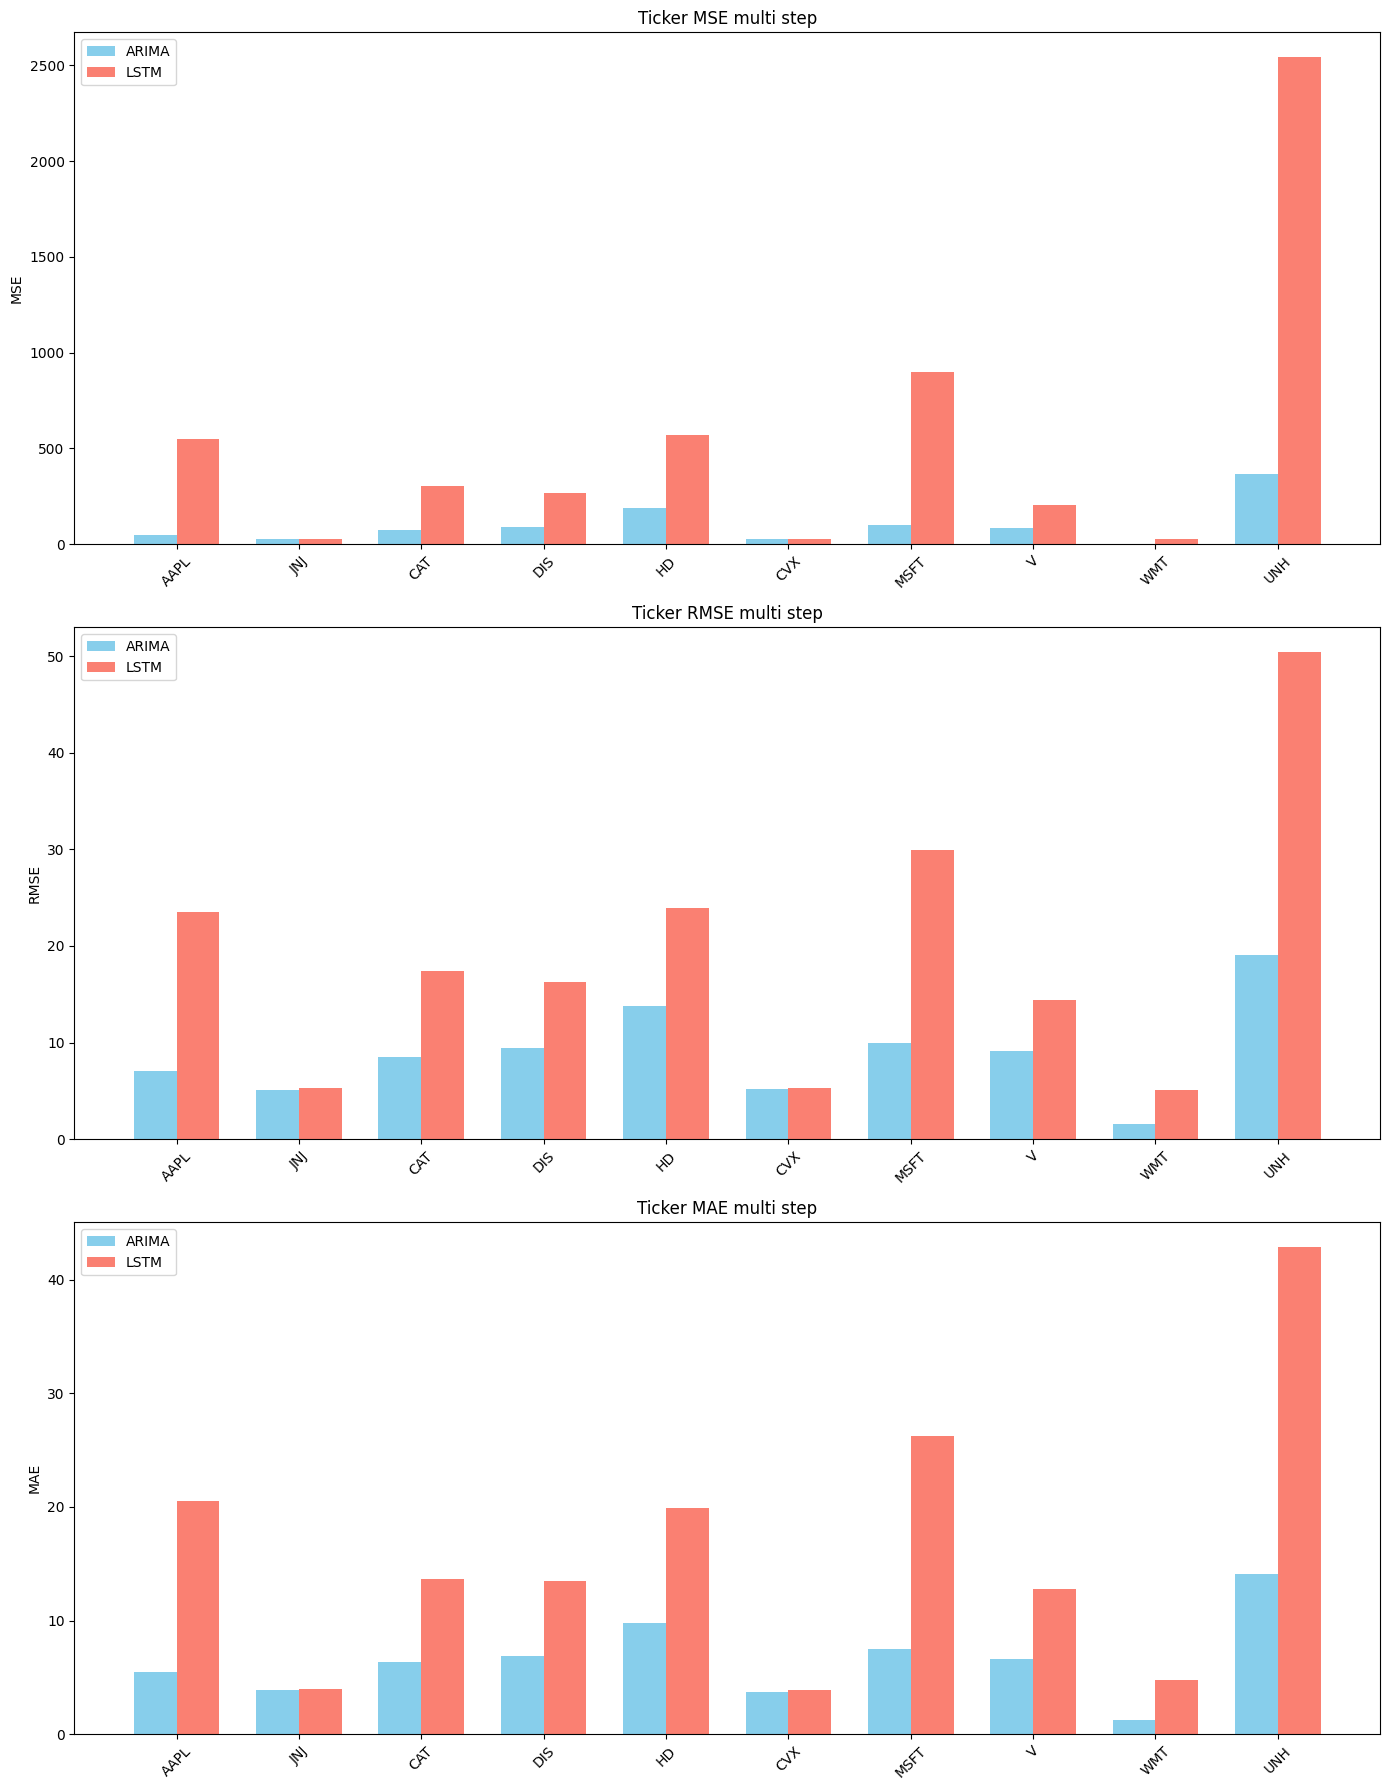

In [200]:
# Trasporre i DataFrame
ARIMA_model_perf_T_df = ARIMA_model_perf_df.T
LSTM_model_perf_T_df = LSTM_model_perf_df.T

# Plotting
metrics = ['MSE', 'RMSE', 'MAE']
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

for i, metric in enumerate(metrics):
    width = 0.35  # larghezza delle barre
    x = np.arange(len(ARIMA_model_perf_T_df.index))  # l'asse x

    # Creazione delle barre per ogni modello
    axs[i].bar(x - width/2, ARIMA_model_perf_T_df[metric], width, label='ARIMA', color='skyblue')
    axs[i].bar(x + width/2, LSTM_model_perf_T_df[metric], width, label='LSTM', color='salmon')

    # Titoli e labels
    axs[i].set_title(f'Ticker {metric} multi step')
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(ARIMA_model_perf_T_df.index, rotation=45)
    axs[i].legend()

# Layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il plot
plt.show()

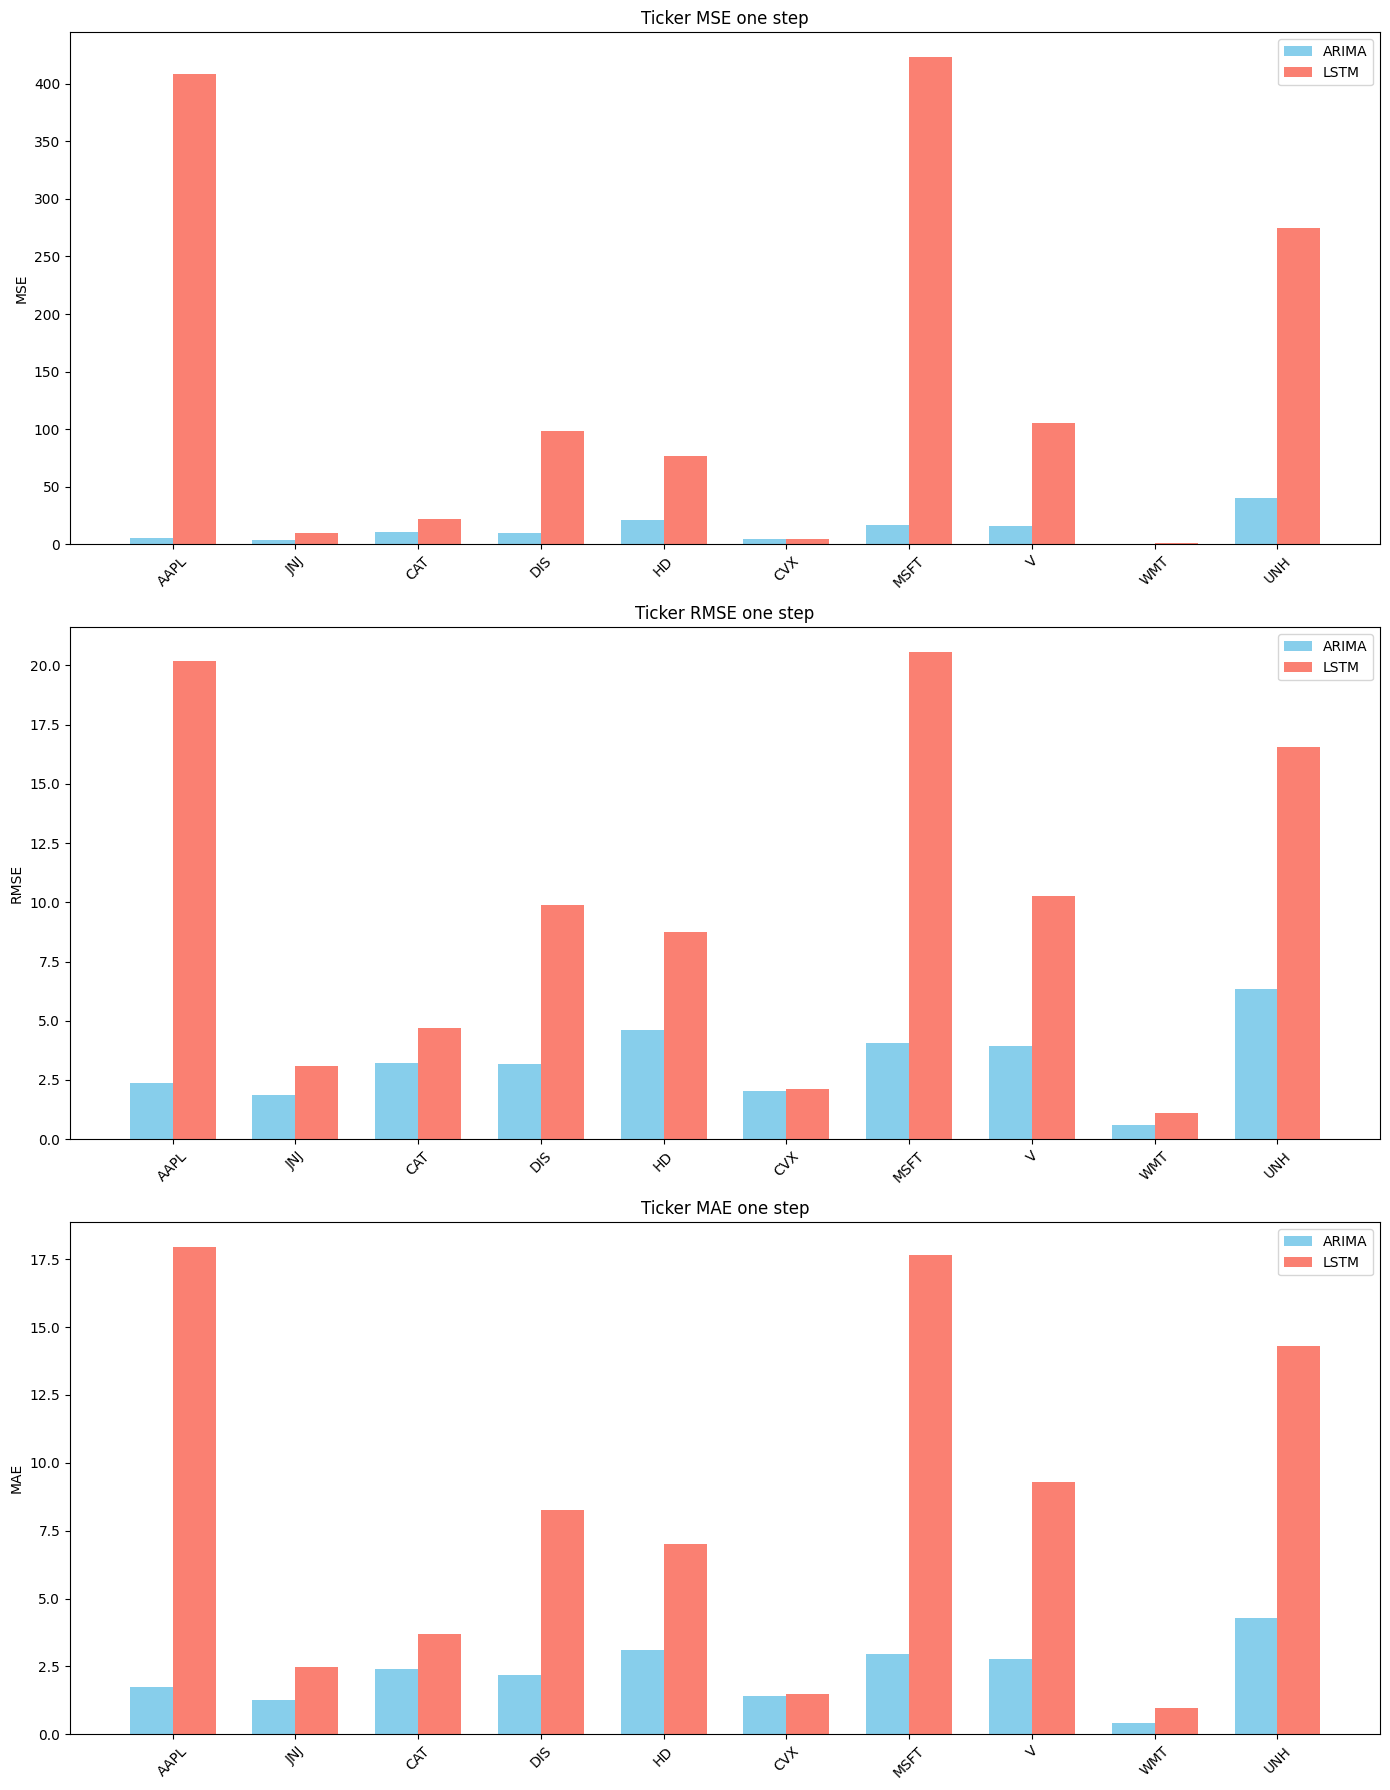

In [201]:
# Trasporre i DataFrame
ARIMA_onestep_model_perf_T_df = ARIMA_onestep_model_perf_df.T
LSTM_one_step_model_perf_T_df = LSTM_one_step_model_perf_df.T

# Plotting
metrics = ['MSE', 'RMSE', 'MAE']
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

for i, metric in enumerate(metrics):
    width = 0.35  # larghezza delle barre
    x = np.arange(len(ARIMA_onestep_model_perf_T_df.index))  # l'asse x

    # Creazione delle barre per ogni modello
    axs[i].bar(x - width/2, ARIMA_onestep_model_perf_T_df[metric], width, label='ARIMA', color='skyblue')
    axs[i].bar(x + width/2, LSTM_one_step_model_perf_T_df[metric], width, label='LSTM', color='salmon')

    # Titoli e labels
    axs[i].set_title(f'Ticker {metric} one step')
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(ARIMA_onestep_model_perf_T_df.index, rotation=45)
    axs[i].legend()

# Layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il plot
plt.show()

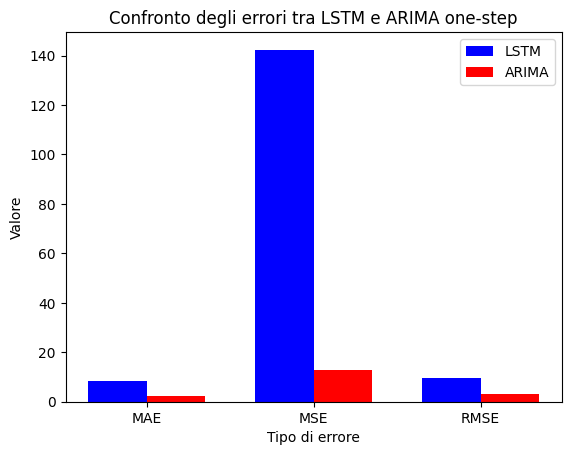

In [137]:
# creazione dell'istogramma per confrontare gli errori dei due modelli ARIMA one-step e LSTM
bar_width = 0.35                                        # larghezza delle barre
index = np.arange(len(LSTM_model_perf_one_step_plot_df.index))        # Posizioni delle barre


plt.bar(index, LSTM_model_perf_one_step_plot_df, bar_width, label='LSTM', color='blue')
plt.bar(index + bar_width, ARIMA_model_perf_one_step_plot_df, bar_width, label='ARIMA', color='red')
plt.xlabel('Tipo di errore')
plt.ylabel('Valore')
plt.title('Confronto degli errori tra LSTM e ARIMA one-step')
plt.xticks(index + bar_width / 2, LSTM_model_perf_one_step_plot_df.index)
plt.legend()
plt.show()


In [138]:
LSTM_mean_model_perf_df['MAPE']

0.08864771225795934

In [139]:
ARIMA_mean_model_perf_df['MAPE']

0.040005186080249965

In [140]:
LSTM_model_perf_plot_df = LSTM_mean_model_perf_df.drop(index='MAPE')
ARIMA_model_perf_plot_df = ARIMA_mean_model_perf_df.drop(index='MAPE')

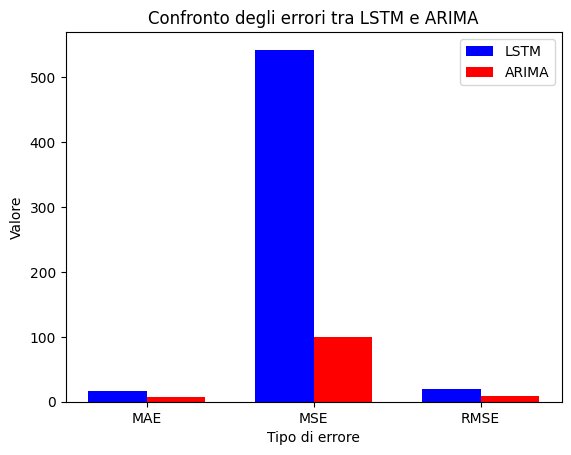

In [141]:
# creazione dell'istogramma per confrontare gli errori dei due modelli ARIMA one-step e LSTM
rand_ticker = random.choice(tickers)                    # scelgo un ticker casuale
bar_width = 0.35                                        # larghezza delle barre
index = np.arange(len(LSTM_model_perf_plot_df.index))        # Posizioni delle barre


plt.bar(index, LSTM_model_perf_plot_df, bar_width, label='LSTM', color='blue')
plt.bar(index + bar_width, ARIMA_model_perf_plot_df, bar_width, label='ARIMA', color='red')
plt.xlabel('Tipo di errore')
plt.ylabel('Valore')
plt.title('Confronto degli errori tra LSTM e ARIMA')
plt.xticks(index + bar_width / 2, LSTM_model_perf_plot_df.index)
plt.legend()
plt.show()

### 6. Allocazione portafoglio

In [64]:
# calcolo matrice di covarianza su dati storici
S = CovarianceShrinkage(act_adj_close_df).ledoit_wolf()


In [65]:
# calcolo delle performance del portafoglio standard non usando modelli di previsione
mu = expected_returns.mean_historical_return(act_adj_close_df)              # media dei ritorni storici 
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
standard_weights = ef.clean_weights()
print(standard_weights)
print(ef.portfolio_performance(verbose=True))

OrderedDict([('AAPL', 0.29883), ('JNJ', 0.0), ('CAT', 0.0), ('DIS', 0.0), ('HD', 0.39169), ('CVX', 0.0), ('MSFT', 0.03376), ('V', 0.0), ('WMT', 0.0), ('UNH', 0.27571)])
Expected annual return: 29.0%
Annual volatility: 19.9%
Sharpe Ratio: 1.36
(0.2903654013617391, 0.1991538034881868, 1.3575708654631664)


In [66]:
# calcolo delle performance del portafoglio standard non usando modelli di previsione
ef_v = EfficientFrontier(mu, S)
weights = ef_v.min_volatility()
min_vol_weights = ef_v.clean_weights()
print(min_vol_weights)
print(ef_v.portfolio_performance(verbose=True))

OrderedDict([('AAPL', 0.04176), ('JNJ', 0.45029), ('CAT', 0.0), ('DIS', 0.07017), ('HD', 0.05411), ('CVX', 0.01683), ('MSFT', 0.0), ('V', 0.0175), ('WMT', 0.33328), ('UNH', 0.01606)])
Expected annual return: 13.9%
Annual volatility: 14.5%
Sharpe Ratio: 0.82
(0.13909682860596487, 0.14497763168151845, 0.8214841643129639)


In [67]:
# calcolo delle performance del portafoglio standard non usando modelli di previsione
ef_r = EfficientFrontier(mu, S)
weights = ef_r._max_return()
max_ret_weights = ef_r.clean_weights()
print(max_ret_weights)
print(ef_r.portfolio_performance(verbose=True))

OrderedDict([('AAPL', 1.0), ('JNJ', 0.0), ('CAT', 0.0), ('DIS', 0.0), ('HD', 0.0), ('CVX', 0.0), ('MSFT', 0.0), ('V', 0.0), ('WMT', 0.0), ('UNH', 0.0)])
Expected annual return: 31.9%
Annual volatility: 28.0%
Sharpe Ratio: 1.07
(0.31903664849388286, 0.28004701444210955, 1.067808735935297)


In [68]:
# trasformo il dataframe dei prezzi delle azione di ogni giorno nella differenza tra il giorno stesso e il giorno precedente
act_adj_close_val_df = act_adj_close_df.iloc[time_step + 1 + all_split:, :]
act_daily_ret_df = act_adj_close_val_df.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]

In [69]:
# dataframe inserire i rendimenti di vari portafogli 
daily_port_ret_df = act_daily_ret_df.copy()
daily_port_ret_df.drop(columns=tickers, inplace=True)

In [70]:
# risk free return, usato per calcolare sharpe ratio
risk_free_ret = 0.015

In [71]:
# funzione per calcolare i rendimenti dei portafogli (in base alla differenza dei pesi)
def add_portfolio(portfolio, weights):
    daily_port_ret_df[f'{portfolio} Return'] = act_daily_ret_df.dot(weights)
    daily_port_ret_df[f'{portfolio} Cum Prod Return'] = (1 + daily_port_ret_df[f'{portfolio} Return']).cumprod()

    print(portfolio)
    print('Weights:')
    print(weights)
   

In [72]:
# calcolo i rendimenti del portafoglio standard con i pesi calcolati per massimizzare lo sharpe ratio
# usando funzioni messe a disposizione dalla libreria pyportfolioopt (per il calcolo usano valori storici dei prezzi)
add_portfolio('PyPort_max_sharpe', np.array(list(standard_weights.values())))

PyPort_max_sharpe
Weights:
[0.29883 0.      0.      0.      0.39169 0.      0.03376 0.      0.
 0.27571]


In [73]:
# calcolo i rendimenti del portafoglio standard con i pesi calcolati per massimizzare lo sharpe ratio
# usando funzioni messe a disposizione dalla libreria pyportfolioopt (per il calcolo usano valori storici dei prezzi)
add_portfolio('PyPort_min_vol', np.array(list(min_vol_weights.values())))

PyPort_min_vol
Weights:
[0.04176 0.45029 0.      0.07017 0.05411 0.01683 0.      0.0175  0.33328
 0.01606]


In [74]:
# calcolo i rendimenti del portafoglio standard con i pesi calcolati per massimizzare lo sharpe ratio
# usando funzioni messe a disposizione dalla libreria pyportfolioopt (per il calcolo usano valori storici dei prezzi)
add_portfolio('PyPort_max_ret', np.array(list(max_ret_weights.values())))

PyPort_max_ret
Weights:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [75]:
# calcolo i pesi in modo che sia uguale per ogni azione
n_assets = len(tickers)
eq_weights = np.ones(n_assets) / n_assets

In [76]:
# calcolo i rendimenti del portafoglio con i pesi equivalenti 
add_portfolio('Eq', eq_weights)

Eq
Weights:
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2399050940.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\2399050940.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


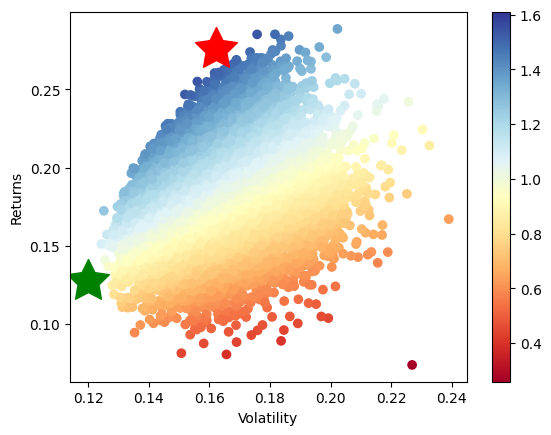

In [77]:
# Calcolo della media e la covarianza dei redimenti giornalieri
mean_daily_returns = LSTM_pred_daily_ret_df.mean()
cov_matrix = LSTM_pred_daily_ret_df.cov()

# Imposta il numero di simulazioni
num_portfolios = 25000
# Imposta un array dei risultati
results = np.zeros((len(tickers)+3, num_portfolios))

for i in range(num_portfolios):
    # Selezioni di pesi random
    weights = np.array(np.random.random(len(tickers)))

    # Ribilanciamento dei pesi per avere somma 1
    weights /= np.sum(weights)

    # Calcolo dei rendimenti e volatilità del portafoglio
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

    # Memorizzazioni nell'array dei risultati
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std_dev
    # Memorizzazione dello Sharpe Ratio - elemento risk free escluso per semplicità
    results[2, i] = (results[0, i] - risk_free_ret) / results[1, i]

    # ciclo sul vettore dei pesi e aggiunta dei dati sull'array dei risultati
    for j in range(len(weights)):
        results[j + 3, i] = weights[j]

# Converte l'array dei risultati in un dataframe pandas
results_frame = pd.DataFrame(results.T, columns=['ret', 'stdev', 'sharpe', tickers[0], tickers[1], tickers[2], tickers[3], tickers[4], tickers[5], tickers[6], tickers[7], tickers[8], tickers[9]])
# Individua il portafoglio con il Sharpe Ratio maggiore
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
# Individua il portafoglio con la deviazione standard minima
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
# Crea il grafico scatter colorato dallo Sharpe Ratio
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
# Visualizza una stella rossa per evidenziare il portafoglio con lo Sharpe Ratio maggiore
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
# Visualizza una stella verde per evidenziare il portafoglio con la varianza minima
plt.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)

plt.show()

In [78]:
# portafoglio ottimale secondo previsioni del modello ARIMA one-step (migliore tra quelli visti)
max_sharpe_port

ret       0.275814
stdev     0.162043
sharpe    1.609538
AAPL      0.079558
JNJ       0.038559
CAT       0.124051
DIS       0.000959
HD        0.257333
CVX       0.024022
MSFT      0.241483
V         0.084895
WMT       0.002220
UNH       0.146920
Name: 3553, dtype: float64

In [79]:
# pesi del portafoglio con sharpe ratio maggiore secondo ARIMA one-step
max_weigths = max_sharpe_port[['AAPL', 'JNJ', 'CAT', 'DIS', 'HD', 'CVX', 'MSFT', 'V', 'WMT', 'UNH']].values

In [80]:
# calcolo i rendimenti del portafoglio con sharpe-ratio maggiore secondo ARIMA one-step
add_portfolio('LSTM_max_sharpe', max_weigths)

LSTM_max_sharpe
Weights:
[0.07955822 0.0385585  0.12405115 0.00095932 0.25733325 0.02402224
 0.24148303 0.08489452 0.00221995 0.1469198 ]


In [81]:
min_vol_port

ret       0.127177
stdev     0.119972
sharpe    0.935025
AAPL      0.027798
JNJ       0.197029
CAT       0.007340
DIS       0.011476
HD        0.010863
CVX       0.046602
MSFT      0.126142
V         0.243866
WMT       0.243782
UNH       0.085101
Name: 8555, dtype: float64

In [82]:
min_volume_weights = min_vol_port[['AAPL', 'JNJ', 'CAT', 'DIS', 'HD', 'CVX', 'MSFT', 'V', 'WMT', 'UNH']].values

In [83]:
# calcolo i rendimenti del portafoglio con sharpe-ratio maggiore secondo ARIMA one-step
add_portfolio('LSTM_min_vol', min_volume_weights)

LSTM_min_vol
Weights:
[0.02779795 0.19702917 0.00734022 0.01147631 0.01086285 0.04660218
 0.12614209 0.24386632 0.24378208 0.08510082]


C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\3831281080.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(ARIMA_max_sharpe_port[1], ARIMA_max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
C:\Users\fanta\AppData\Local\Temp\ipykernel_22280\3831281080.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(ARIMA_min_vol_port[1], ARIMA_min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


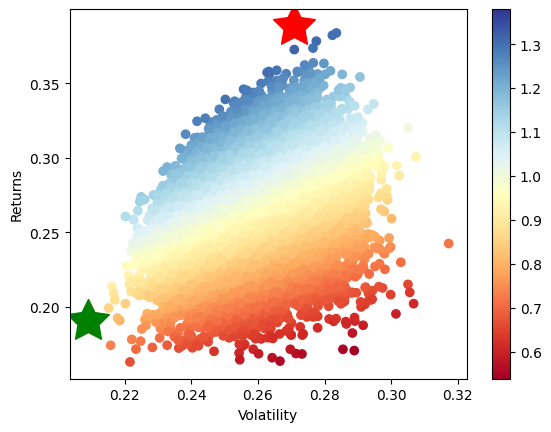

In [230]:
# Calcolo della media e la covarianza dei redimenti giornalieri
ARIMA_mean_daily_returns = ARIMA_pred_daily_ret_df.mean()
ARIMA_cov_matrix = ARIMA_pred_daily_ret_df.cov()

# Imposta il numero di simulazioni
num_portfolios = 25000
# Imposta un array dei risultati
results = np.zeros((len(tickers)+3, num_portfolios))

for i in range(num_portfolios):
    # Selezioni di pesi random
    weights = np.array(np.random.random(len(tickers)))

    # Ribilanciamento dei pesi per avere somma 1
    weights /= np.sum(weights)

    # Calcolo dei rendimenti e volatilità del portafoglio
    ARIMA_portfolio_return = np.sum(ARIMA_mean_daily_returns * weights) * 252
    ARIMA_portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(ARIMA_cov_matrix, weights))) * np.sqrt(252)

    # Memorizzazioni nell'array dei risultati
    results[0, i] = ARIMA_portfolio_return
    results[1, i] = ARIMA_portfolio_std_dev
    # Memorizzazione dello Sharpe Ratio - elemento risk free escluso per semplicità
    results[2, i] = (results[0, i] - risk_free_ret) / results[1, i]

    # ciclo sul vettore dei pesi e aggiunta dei dati sull'array dei risultati
    for j in range(len(weights)):
        results[j + 3, i] = weights[j]

# Converte l'array dei risultati in un dataframe pandas
ARIMA_results_frame = pd.DataFrame(results.T, columns=['ret', 'stdev', 'sharpe', tickers[0], tickers[1], tickers[2], tickers[3], tickers[4], tickers[5], tickers[6], tickers[7], tickers[8], tickers[9]])
# Individua il portafoglio con il Sharpe Ratio maggiore
ARIMA_max_sharpe_port = ARIMA_results_frame.iloc[ARIMA_results_frame['sharpe'].idxmax()]
# Individua il portafoglio con la deviazione standard minima
ARIMA_min_vol_port = ARIMA_results_frame.iloc[ARIMA_results_frame['stdev'].idxmin()]
# Crea il grafico scatter colorato dallo Sharpe Ratio
plt.scatter(ARIMA_results_frame.stdev, ARIMA_results_frame.ret, c=ARIMA_results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
# Visualizza una stella rossa per evidenziare il portafoglio con lo Sharpe Ratio maggiore
plt.scatter(ARIMA_max_sharpe_port[1], ARIMA_max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
# Visualizza una stella verde per evidenziare il portafoglio con la varianza minima
plt.scatter(ARIMA_min_vol_port[1], ARIMA_min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)

plt.show()

In [101]:
ARIMA_max_sharpe_port

ret       0.357542
stdev     0.262183
sharpe    1.306500
AAPL      0.269742
JNJ       0.145176
CAT       0.136006
DIS       0.012391
HD        0.089644
CVX       0.020276
MSFT      0.211630
V         0.026844
WMT       0.031905
UNH       0.056386
Name: 8989, dtype: float64

In [105]:
# pesi del portafoglio con sharpe ratio maggiore secondo ARIMA one-step
ARIMA_max_weigths = ARIMA_max_sharpe_port[['AAPL', 'JNJ', 'CAT', 'DIS', 'HD', 'CVX', 'MSFT', 'V', 'WMT', 'UNH']].values

In [106]:
# calcolo i rendimenti del portafoglio con sharpe-ratio maggiore secondo ARIMA one-step
add_portfolio('ARIMA_max_sharpe', ARIMA_max_weigths)

ARIMA_max_sharpe
Weights:
[0.26974191 0.14517618 0.13600594 0.0123906  0.08964419 0.02027569
 0.21163024 0.02684384 0.0319051  0.0563863 ]


In [231]:
ARIMA_min_vol_port

ret       0.190588
stdev     0.208879
sharpe    0.840623
AAPL      0.063377
JNJ       0.263933
CAT       0.029842
DIS       0.139822
HD        0.071208
CVX       0.010071
MSFT      0.031566
V         0.056545
WMT       0.307722
UNH       0.025913
Name: 12553, dtype: float64

In [111]:
# pesi del portafoglio con sharpe ratio maggiore secondo ARIMA one-step
ARIMA_min_vol = ARIMA_min_vol_port[['AAPL', 'JNJ', 'CAT', 'DIS', 'HD', 'CVX', 'MSFT', 'V', 'WMT', 'UNH']].values

In [112]:
# calcolo i rendimenti del portafoglio con sharpe-ratio maggiore secondo ARIMA one-step
add_portfolio('ARIMA_in_vol', ARIMA_min_vol)

ARIMA_in_vol
Weights:
[0.0382768  0.27237281 0.01774255 0.02265794 0.13489443 0.05195191
 0.00866703 0.17955087 0.26734288 0.00654277]


In [96]:
# function for getting inverse of expected return using predicted Adj Close price
# used to get optimum weights that maximize this expected return
def exp_ret_inv(weights):
    pred_daily_port_ret = LSTM_pred_daily_ret_df.dot(weights)
    exp_ret = pred_daily_port_ret.mean()
    return 1 / exp_ret

In [97]:
# expected return maximization using predicted Adj Close price
weights0 = eq_weights # initial weights
# bounds: weight should be between 0.0 and 1.0
bnds = tuple((0.0, 1.0) for i in range(n_assets))
# constraints: weights should add up to 1.0
cons = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.0})

res = minimize(exp_ret_inv, weights0, method='SLSQP', bounds=bnds, constraints=cons)
pred_weights = res.x

In [86]:
add_portfolio('LSTM_max_ret', pred_weights)

LSTM_max_ret
Weights:
[1.00000000e+00 3.10889044e-14 0.00000000e+00 1.27235318e-13
 9.74355476e-14 0.00000000e+00 3.54638723e-14 0.00000000e+00
 8.89563960e-14 0.00000000e+00]


In [152]:
# function for getting inverse of expected return using predicted Adj Close price
# used to get optimum weights that maximize this expected return
def ARIMA_exp_ret_inv(weights):
    pred_daily_port_ret = ARIMA_pred_daily_ret_df.dot(weights)
    exp_ret = pred_daily_port_ret.mean()
    return 1 / exp_ret

In [153]:
# expected return maximization using predicted Adj Close price
weights0 = eq_weights # initial weights
# bounds: weight should be between 0.0 and 1.0
bnds = tuple((0.0, 1.0) for i in range(n_assets))
# constraints: weights should add up to 1.0
cons = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.0})

res = minimize(ARIMA_exp_ret_inv, weights0, method='SLSQP', bounds=bnds, constraints=cons)
ARIMA_pred_weights = res.x

In [154]:
add_portfolio('ARIMA_max_ret', ARIMA_pred_weights)

ARIMA_max_ret
Weights:
[1.00000000e+00 7.35371366e-14 3.29369471e-14 0.00000000e+00
 2.75915601e-14 3.65265033e-15 0.00000000e+00 0.00000000e+00
 3.77563010e-14 2.04665688e-15]


In [155]:
# stampo i rendimenti di tutti i portafogli creati 
daily_port_ret_df

PyPort_max_sharpe Return  PyPort_max_sharpe Cum Prod Return  \
Date                                                                      
2020-05-29                  0.006188                           1.006188   
2020-06-01                  0.002699                           1.008903   
2020-06-02                  0.010695                           1.019693   
2020-06-03                  0.000536                           1.020240   
2020-06-04                 -0.012781                           1.007200   
...                              ...                                ...   
2021-12-23                  0.003353                           1.874343   
2021-12-27                  0.016866                           1.905956   
2021-12-28                  0.002122                           1.910000   
2021-12-29                  0.006121                           1.921692   
2021-12-30                 -0.003711                           1.914561   

            PyPort_min_vol Return  PyPort_min_vol Cum Prod Return  \
Date                                                                
2020-05-29               0.007766                        1.007766   
2020-06-01              -0.003680                        1.004058   
2020-06-02               0.005102                        1.009180   
2020-06-03               0.002600                        1.011804   
2020-06-04              -0.010247                        1.001437   
...                           ...                             ...   
2021-12-23               0.001249                        1.271889   
2021-12-27               0.008931                        1.283248   
2021-12-28               0.007846                        1.293316   
2021-12-29               0.003503                        1.297847   
2021-12-30               0.003021                        1.301768   

            PyPort_max_ret Return  PyPort_max_ret Cum Prod Return  Eq Return  \
Date                                                                           
2020-05-29              -0.000974                        0.999026   0.005468   
2020-06-01               0.012298                        1.011312   0.002041   
2020-06-02               0.004629                        1.015994   0.010026   
2020-06-03               0.005505                        1.021587   0.009122   
2020-06-04              -0.008612                        1.012789  -0.007628   
...                           ...                             ...        ...   
2021-12-23               0.003644                        2.237148   0.004177   
2021-12-27               0.022975                        2.288546   0.011028   
2021-12-28              -0.005767                        2.275347   0.003811   
2021-12-29               0.000502                        2.276490   0.002244   
2021-12-30              -0.006578                        2.261514  -0.001605   

            Eq Cum Prod Return  LSTM_max_sharpe Return  \
Date                                                     
2020-05-29            1.005468                0.006816   
2020-06-01            1.007520               -0.000400   
2020-06-02            1.017622                0.013488   
2020-06-03            1.026905                0.005118   
2020-06-04            1.019072               -0.009764   
...                        ...                     ...   
2021-12-23            1.551632                0.004772   
2021-12-27            1.568743                0.014534   
2021-12-28            1.574722                0.001526   
2021-12-29            1.578256                0.004851   
2021-12-30            1.575723               -0.004065   

            LSTM_max_sharpe Cum Prod Return  LSTM_min_vol Return  \
Date                                                               
2020-05-29                         1.006816             0.006442   
2020-06-01                         1.006413            -0.002352   
2020-06-02                         1.019988             0.006933   
20

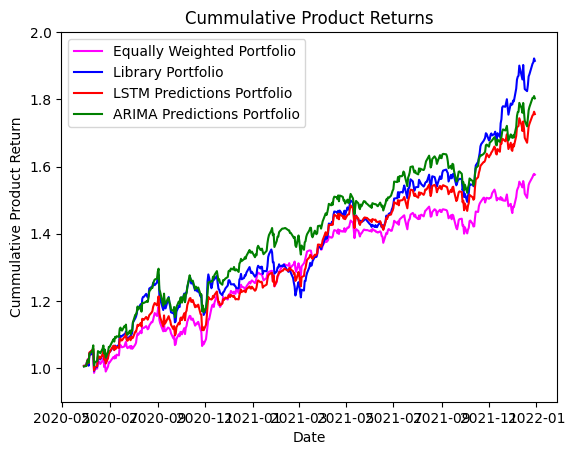

In [120]:
# plot dei portafogli 
plt.plot(daily_port_ret_df.index, daily_port_ret_df['Eq Cum Prod Return'], 
         label='Equally Weighted Portfolio', color='fuchsia')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['PyPort_max_sharpe Cum Prod Return'], 
         label='Library Portfolio', color='blue')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['LSTM_max_sharpe Cum Prod Return'], 
         label='LSTM Predictions Portfolio', color='red')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['ARIMA_max_sharpe Cum Prod Return'], 
         label='ARIMA Predictions Portfolio', color='green')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
plt.ylim(0.9, 2)
plt.legend()
plt.show()

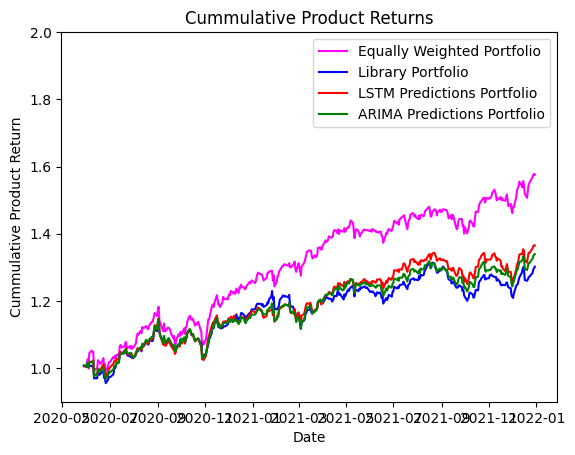

In [118]:
# plot dei portafogli 
plt.plot(daily_port_ret_df.index, daily_port_ret_df['Eq Cum Prod Return'], 
         label='Equally Weighted Portfolio', color='fuchsia')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['PyPort_min_vol Cum Prod Return'], 
         label='Library Portfolio', color='blue')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['LSTM_min_vol Cum Prod Return'], 
         label='LSTM Predictions Portfolio', color='red')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['ARIMA_in_vol Cum Prod Return'], 
         label='ARIMA Predictions Portfolio', color='green')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
plt.ylim(0.9, 2)
plt.legend()
plt.show()

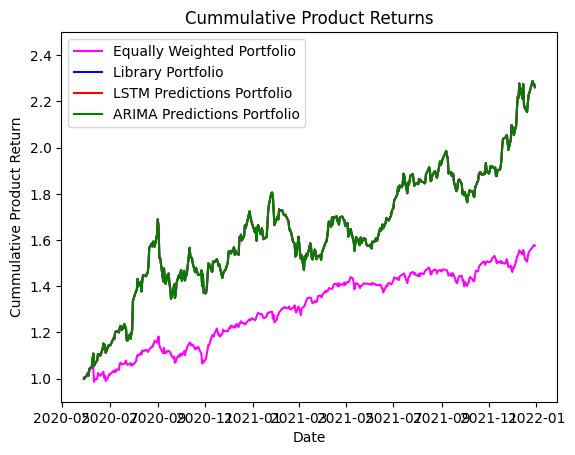

In [157]:
# plot dei portafogli 
plt.plot(daily_port_ret_df.index, daily_port_ret_df['Eq Cum Prod Return'], 
         label='Equally Weighted Portfolio', color='fuchsia')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['PyPort_max_ret Cum Prod Return'], 
         label='Library Portfolio', color='blue')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['LSTM_max_ret Cum Prod Return'], 
         label='LSTM Predictions Portfolio', color='red')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['ARIMA_max_ret Cum Prod Return'], 
         label='ARIMA Predictions Portfolio', color='green')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
plt.ylim(0.9, 2.5)
plt.legend()
plt.show()

In [ ]:
LSTM_one_step_model_loss_df.to_csv('LSTM_onestep_modelloss.csv', index=False)
LSTM_one_step_prediction_df.to_csv('LSTM_onestep.csv', index=False)

In [ ]:
LSTM_prediction_df.to_csv('LSTM.csv', index=False)
LSTM_model_loss_df.to_csv('LSTM_modelloss.csv', index=False)

In [ ]:
ARIMA_prediction_df.to_csv('ARIMA.csv', index=False)
ARIMA_onestep_prediction_df.to_csv('ARIMA_onestep.csv', index=False)
ARIMA_model_loss_df.to_csv('ARIMA_modelloss.csv', index=False)
ARIMA_onestep_model_loss_df.to_csv('ARIMA_onestep_modelloss.csv', index=False)
